In [191]:
import pandas as pd
import numpy as np

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score,
    matthews_corrcoef, confusion_matrix, accuracy_score, precision_score, recall_score, auc
)
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc as calculate_auc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.experimental import enable_halving_search_cv  # 👈 REQUIRED to use HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
import shap
# Ignore warnings for clean output
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import label_binarize
from sklearn.base import clone

In [2]:
X_train_multi = pd.read_csv(r"C:\Users\ghaza\Desktop\FYP\Application\AI\data\processed\balanced_X_train_multi.csv")
y_train_multi = pd.read_csv(r"C:\Users\ghaza\Desktop\FYP\Application\AI\data\processed\balanced_y_train_multi.csv").squeeze()
X_test = pd.read_csv(r"C:\Users\ghaza\Desktop\FYP\Application\AI\data\processed\X_test.csv")
y_test_multi = pd.read_csv(r"C:\Users\ghaza\Desktop\FYP\Application\AI\data\processed\y_test_multi.csv").squeeze()


# Verify loaded data
print("Datasets Loaded:")
print(f"X_train_multi: {X_train_multi.shape}")
print(f"y_train_multi: {y_train_multi.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test_multi: {y_test_multi.shape}")

Datasets Loaded:
X_train_multi: (330556, 7)
y_train_multi: (330556,)
X_test: (52487, 7)
y_test_multi: (52487,)


In [3]:
# For y_train_multi
if isinstance(y_train_multi, pd.DataFrame) and y_train_multi.shape[1] == 1:
    y_train_multi = y_train_multi.values.ravel()
elif isinstance(y_train_multi, pd.Series):
    y_train_multi = y_train_multi.values
elif isinstance(y_train_multi, np.ndarray) and y_train_multi.ndim > 1:
    y_train_multi = y_train_multi.ravel()

# For y_test_multi
if isinstance(y_test_multi, pd.DataFrame) and y_test_multi.shape[1] == 1:
    y_test_multi = y_test_multi.values.ravel()
elif isinstance(y_test_multi, pd.Series):
    y_test_multi = y_test_multi.values
elif isinstance(y_test_multi, np.ndarray) and y_test_multi.ndim > 1:
    y_test_multi = y_test_multi.ravel()

# === Verification ===
print("Datasets Loaded and Verified:")
print(f"X_train_multi: {X_train_multi.shape}")
print(f"y_train_multi: {y_train_multi.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test_multi: {y_test_multi.shape}")

Datasets Loaded and Verified:
X_train_multi: (330556, 7)
y_train_multi: (330556,)
X_test: (52487, 7)
y_test_multi: (52487,)


In [8]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(objective="multi:softprob", num_class=5, use_label_encoder=False, eval_metric="mlogloss", verbosity=0),
    "LightGBM": LGBMClassifier(objective="multiclass", num_class=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000),
    "MLP": MLPClassifier(max_iter=1000, random_state=42)
}

In [10]:
param_grid_xgb = {"n_estimators": [50], "max_depth": [3, 5], "learning_rate": [0.05, 0.1]}
param_grid_lgb = {"n_estimators": [50], "max_depth": [5, 10], "learning_rate": [0.05, 0.1]}
param_grid_dt = {"max_depth": [None, 5, 10], "min_samples_split": [2, 5]}
param_grid_rf = {"n_estimators": [50, 100], "max_depth": [None, 5, 10], "min_samples_split": [2, 5]}
param_grid_gb = {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1], "max_depth": [3, 5]}
param_grid_lr = {"C": [0.1, 1.0, 10.0], "penalty": ["l2"]}
param_grid_mlp = {"hidden_layer_sizes": [(100,), (50, 50)], "activation": ["relu", "tanh"], "learning_rate_init": [0.001]}

In [12]:
models_with_grids = {
    "Decision Tree": {"model": models["Decision Tree"], "param_grid": param_grid_dt},
    "Random Forest": {"model": models["Random Forest"], "param_grid": param_grid_rf},
    "XGBoost": {"model": models["XGBoost"], "param_grid": param_grid_xgb},
    "LightGBM": {"model": models["LightGBM"], "param_grid": param_grid_lgb},
    "Gradient Boosting": {"model": models["Gradient Boosting"], "param_grid": param_grid_gb},
    "Logistic Regression": {"model": models["Logistic Regression"], "param_grid": param_grid_lr},
     "MLP": {"model": models["MLP"], "param_grid": param_grid_mlp}
}

In [14]:
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [16]:
def run_multiclass_grid_search(X_train, y_train, X_test, y_test, models_with_grids, cv_strategy, scoring="f1_macro"):
    import pandas as pd
    import numpy as np
    from sklearn.metrics import (
        classification_report, accuracy_score, f1_score, matthews_corrcoef,
        confusion_matrix, precision_recall_curve, roc_auc_score, auc
    )
    from sklearn.model_selection import GridSearchCV
    from itertools import product

    grid_search_results = {}
    trained_models = {}
    threshold = 0.1  # 10% gap for over/under-fitting check

    def check_over_under(train_acc, test_acc):
        if train_acc > test_acc + threshold:
            return "Potential Overfitting Detected"
        elif test_acc > train_acc + threshold:
            return "Potential Underfitting Detected"
        else:
            return "Balanced Performance"

    def manual_search(model_class, param_grid, model_name):
        print(f"\nRunning manual grid search for {model_name}...")
        keys, values = zip(*param_grid.items())
        best_score = -np.inf
        best_model = None
        best_params = None

        for combo in product(*values):
            params = dict(zip(keys, combo))
            try:
                model = model_class(**params)
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                score = f1_score(y_test, preds, average="macro")
                
                if score > best_score:
                    best_score = score
                    best_model = model
                    best_params = params
            except Exception as e:
                print(f"Skipping {params} due to error: {e}")

        return best_model, best_params

    for model_name, model_data in models_with_grids.items():
        print(f"\nStarting grid search for {model_name}...")
        model = model_data["model"]
        param_grid = model_data["param_grid"]

        if model_name in ["XGBoost", "LightGBM"]:
            best_model, best_params = manual_search(model.__class__, param_grid, model_name)
        else:
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                scoring=scoring,
                cv=cv_strategy,
                verbose=2,
                n_jobs=-1
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_

        trained_models[model_name] = best_model
        print(f"Best Parameters for {model_name}: {best_params}")

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        fit_status = check_over_under(train_acc, test_acc)

        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"{fit_status}")

        f1 = f1_score(y_test, y_test_pred, average="macro")
        mcc = matthews_corrcoef(y_test, y_test_pred)
        cm = confusion_matrix(y_test, y_test_pred)
        specificity = cm[0, 0] / np.sum(cm[0]) if cm.shape[0] > 1 else None

        auc_roc = auc_pr = None
        if hasattr(best_model, "predict_proba"):
            try:
                y_probs = best_model.predict_proba(X_test)
                auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr')
                auc_pr = np.mean([
                    auc(*precision_recall_curve((y_test == i).astype(int), y_probs[:, i])[1::-1])
                    for i in np.unique(y_test)
                ])
            except Exception as e:
                print(f"AUC calculation failed for {model_name}: {e}")

        print(f"\nClassification Report for {model_name}:\n", classification_report(y_test, y_test_pred))

        grid_search_results[model_name] = {
            "Best Parameters": best_params,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "F1-Score": f1,
            "AUC-PR": auc_pr,
            "AUC-ROC": auc_roc,
            "MCC": mcc,
            "Specificity": specificity,
            "Fit Status": fit_status
        }

        print(f"Results for {model_name}:")
        print(grid_search_results[model_name])

    results_df = pd.DataFrame(grid_search_results).T
    print("\nSummary of All Model Results:")
    print(results_df)

    return trained_models, grid_search_results, results_df

In [18]:
trained_models, grid_results, summary_df = run_multiclass_grid_search(
    X_train=X_train_multi,
    y_train=y_train_multi,
    X_test=X_test,
    y_test=y_test_multi,
    models_with_grids=models_with_grids,
    cv_strategy=cv_strategy,
    scoring="f1_macro"
)


Starting grid search for Decision Tree...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}
Train Accuracy: 1.0000
Test Accuracy: 0.7544
Potential Overfitting Detected

Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.29      0.44      0.35      2683
           1       0.95      0.82      0.88     38015
           2       0.05      0.17      0.08       797
           3       0.77      0.85      0.81      5512
           4       0.35      0.44      0.39      5480

    accuracy                           0.75     52487
   macro avg       0.48      0.54      0.50     52487
weighted avg       0.82      0.75      0.78     52487

Results for Decision Tree:
{'Best Parameters': {'max_depth': None, 'min_samples_split': 2}, 'Train Accuracy': 1.0, 'Test Accuracy': 0.7543772743727019, 'F1-Score': 0.5014763838607188, 'AUC-PR': 0.53770375203279

In [128]:
import os
import joblib

def save_models_individually(model_dict, save_dir):
    """
    Saves each model from the given dictionary to a .pkl file in the specified directory.
    Filenames are derived from model names.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    for model_name, model_obj in model_dict.items():
        # Clean filename
        clean_name = model_name.replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename = os.path.join(save_dir, f"{clean_name}.pkl")
        joblib.dump(model_obj, filename)
        print(f"Saved: {filename}")

save_models_individually(
    model_dict=trained_models,
    save_dir=r"C:\Users\ghaza\Desktop\FYP\Application\AI\models\Multi Training - GridSearch"
)

Saved: C:\Users\ghaza\Desktop\FYP\Application\AI\models\Multi Training - GridSearch\Decision_Tree.pkl
Saved: C:\Users\ghaza\Desktop\FYP\Application\AI\models\Multi Training - GridSearch\Random_Forest.pkl
Saved: C:\Users\ghaza\Desktop\FYP\Application\AI\models\Multi Training - GridSearch\XGBoost.pkl
Saved: C:\Users\ghaza\Desktop\FYP\Application\AI\models\Multi Training - GridSearch\LightGBM.pkl
Saved: C:\Users\ghaza\Desktop\FYP\Application\AI\models\Multi Training - GridSearch\Gradient_Boosting.pkl
Saved: C:\Users\ghaza\Desktop\FYP\Application\AI\models\Multi Training - GridSearch\Logistic_Regression.pkl
Saved: C:\Users\ghaza\Desktop\FYP\Application\AI\models\Multi Training - GridSearch\MLP.pkl


In [61]:
def plot_model_metric_bars(results_df):
    """
    Plots grouped bar charts for each metric:
    Train vs Test values side-by-side per model.
    """
    # Define metrics (both train/test where applicable)
    metric_groups = [
        ("Train Accuracy", "Test Accuracy", "Accuracy"),
        ("F1-Score", "F1-Score", "F1-Macro"),
        ("AUC-PR", "AUC-PR", "AUC-PR"),
        ("AUC-ROC", "AUC-ROC", "AUC-ROC")
    ]

    color_train = "lightsteelblue"
    color_test = "peachpuff"

    for train_col, test_col, display_name in metric_groups:
        if train_col not in results_df.columns or test_col not in results_df.columns:
            print(f"Skipping {display_name}: missing columns.")
            continue

        x = np.arange(len(results_df))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))
        bars_train = ax.bar(x - width / 2, results_df[train_col], width, label="Train", color=color_train)
        bars_test = ax.bar(x + width / 2, results_df[test_col], width, label="Test", color=color_test)

        # Add data labels
        for bars in [bars_train, bars_test]:
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height,
                    f"{height:.2f}",
                    ha="center", va="bottom", fontsize=9
                )

        ax.set_ylabel(display_name)
        ax.set_title(f"{display_name} Comparison (Train vs Test)")
        ax.set_xticks(x)
        ax.set_xticklabels(results_df.index, rotation=45, ha="right")
        ax.legend()
        plt.tight_layout()
        plt.show()

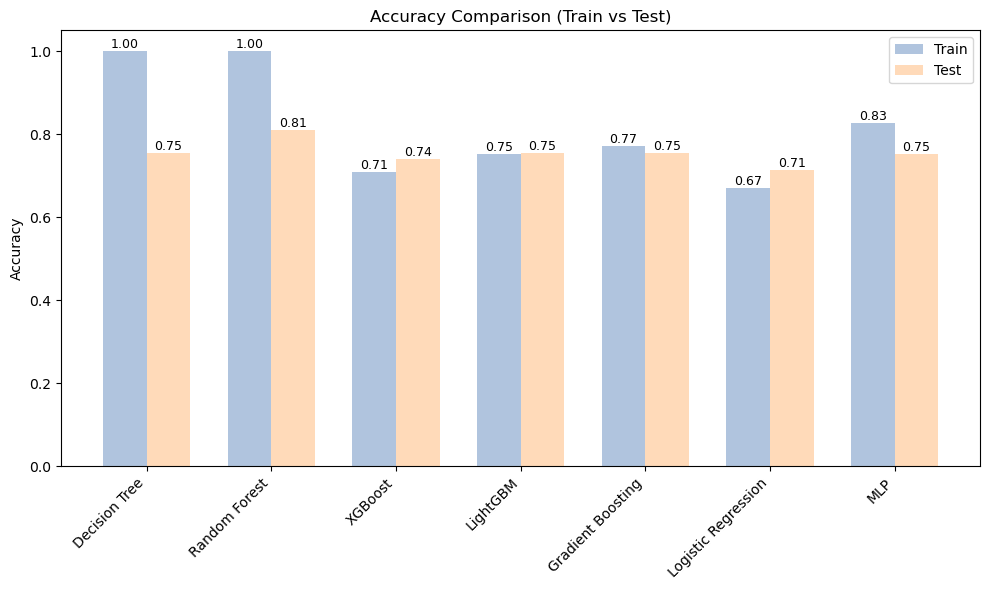

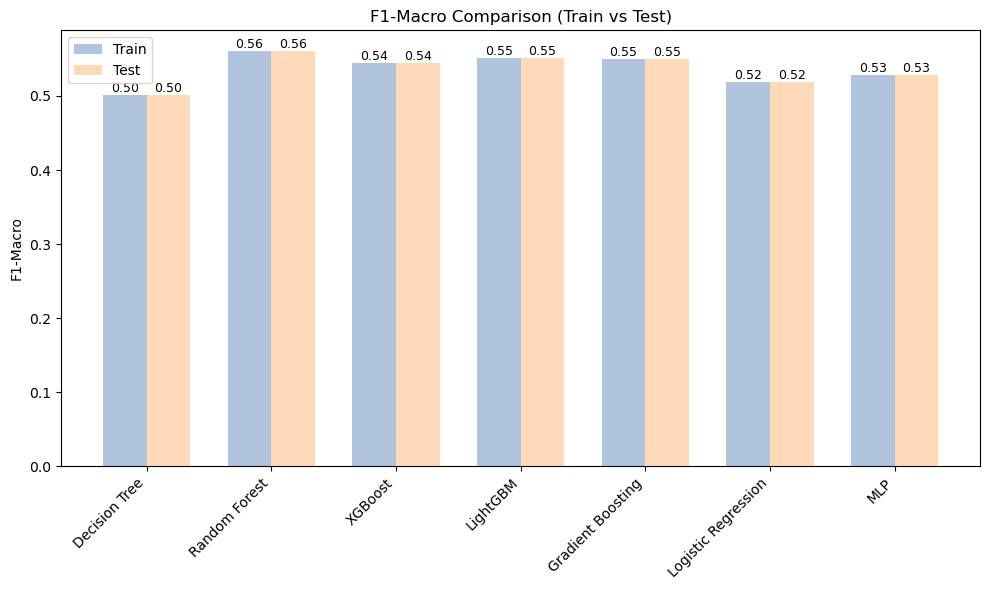

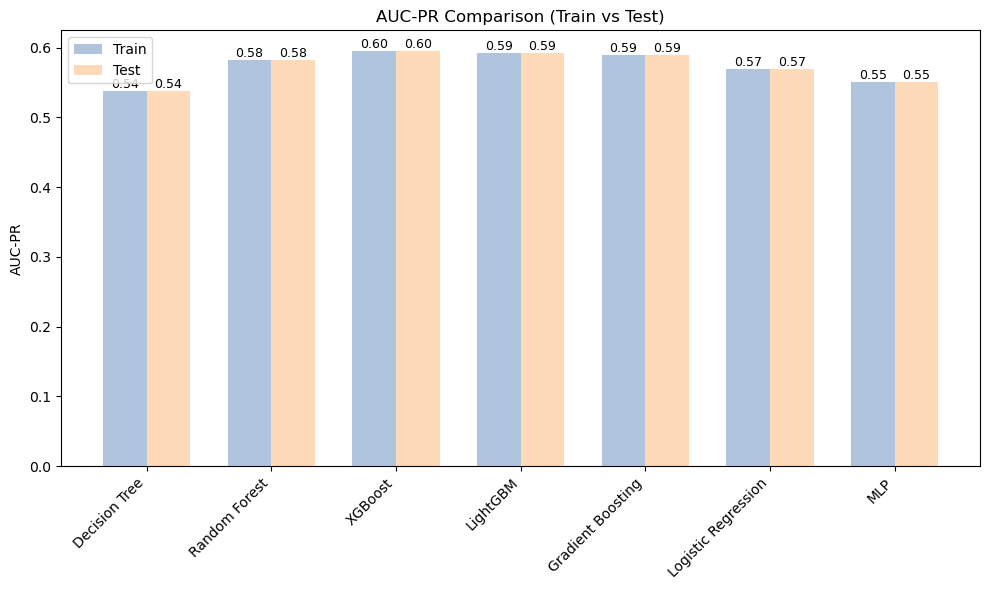

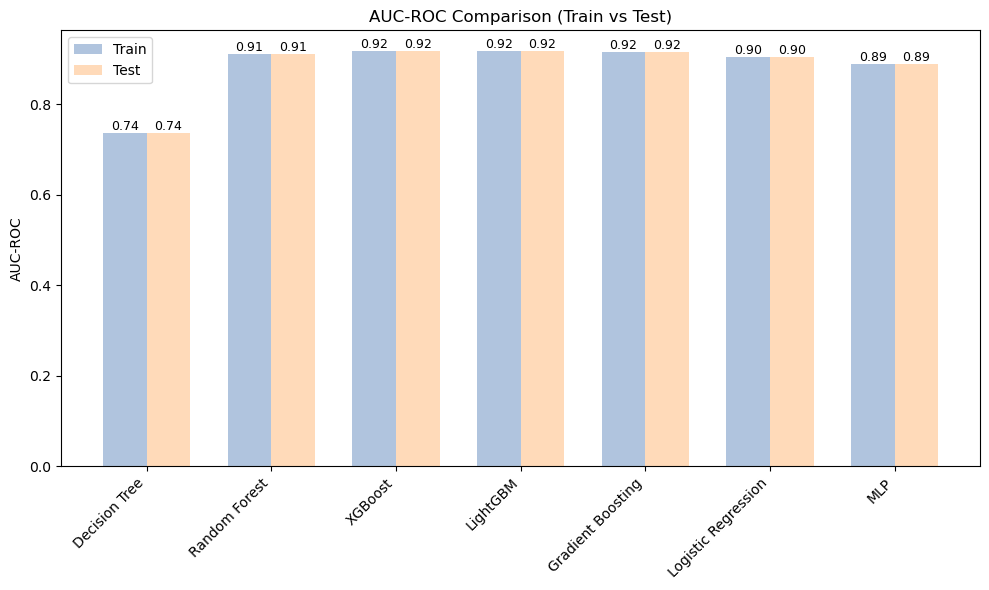

In [62]:
plot_model_metric_bars(
    results_df=summary_df  # From your run_multiclass_grid_search
)

In [111]:
def plot_roc_pr_curves(model_dict, X_test, y_test, title_prefix="Model Evaluation"):
    class_labels = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=class_labels)

    for name, model in model_dict.items():
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(X_test)

                # === ROC Curve ===
                plt.figure(figsize=(8, 5))
                for i in range(len(class_labels)):
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")
                plt.plot([0, 1], [0, 1], 'k--')
                plt.title(f"{title_prefix} - ROC Curve: {name}")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend(loc="lower right", fontsize='small')
                plt.grid(True)
                plt.tight_layout()
                plt.show()

                # === Precision-Recall Curve ===
                plt.figure(figsize=(8, 5))
                for i in range(len(class_labels)):
                    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
                    ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])
                    plt.plot(recall, precision, label=f"Class {class_labels[i]} (AP = {ap:.2f})")
                plt.title(f"{title_prefix} - Precision-Recall Curve: {name}")
                plt.xlabel("Recall")
                plt.ylabel("Precision")
                plt.legend(loc="lower left", fontsize='small')
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Error plotting for {name}: {e}")

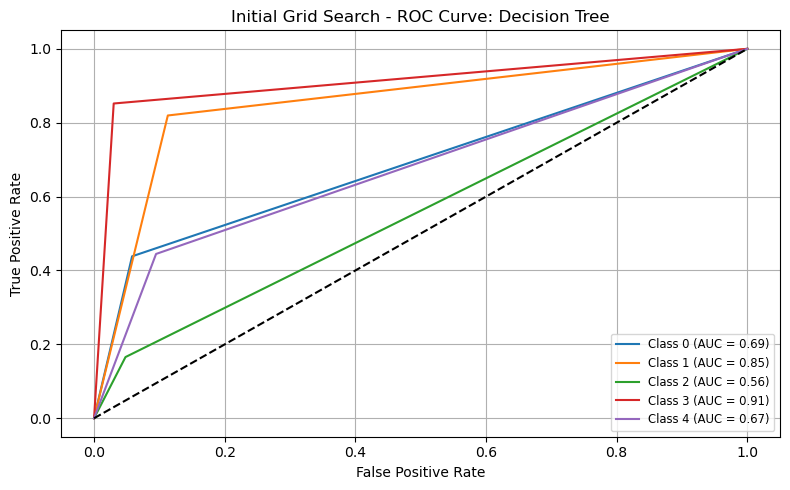

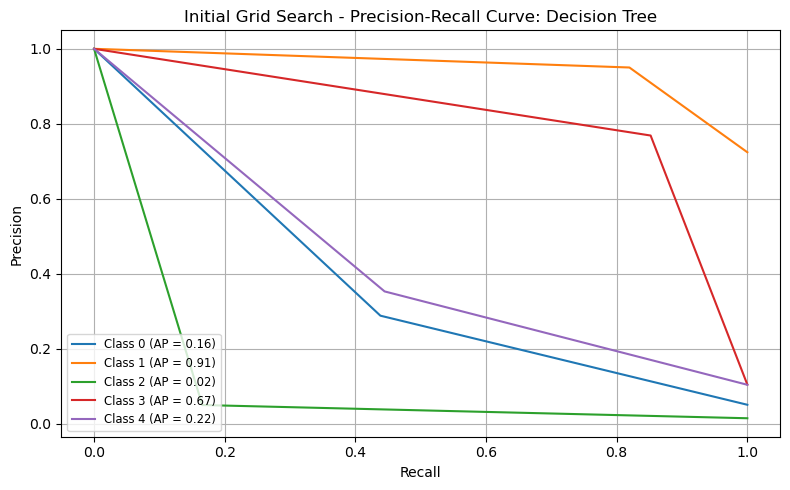

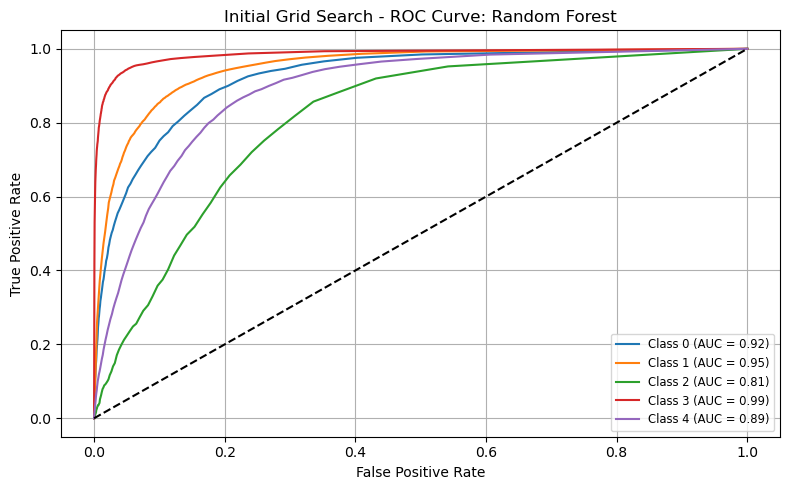

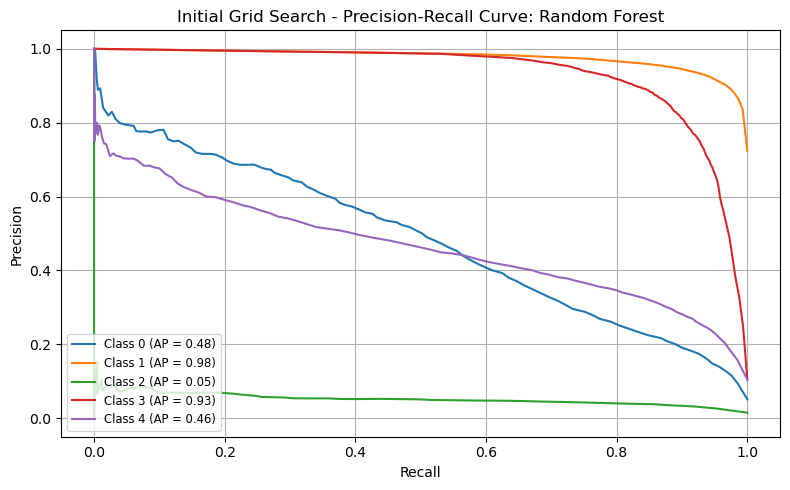

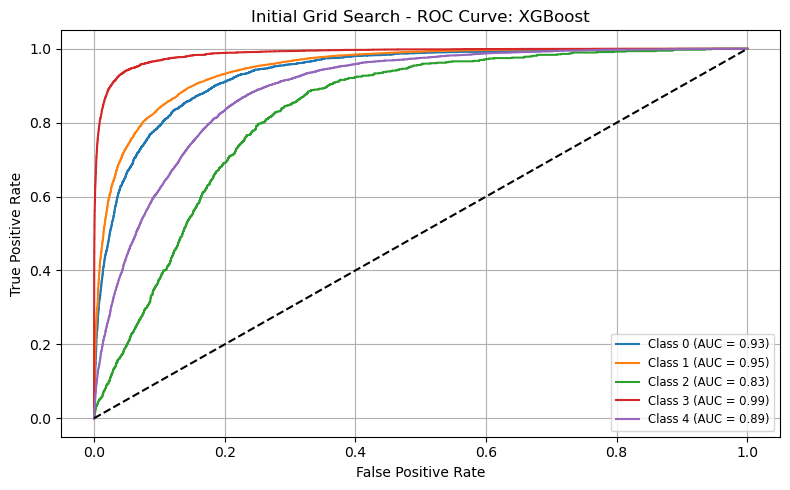

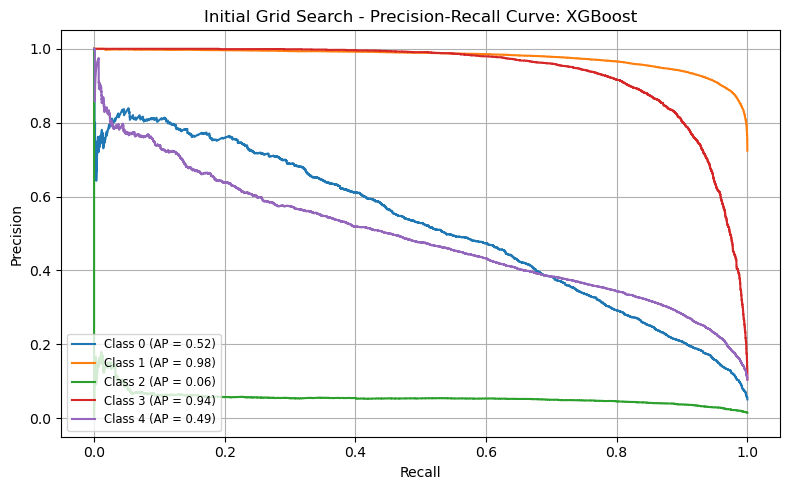

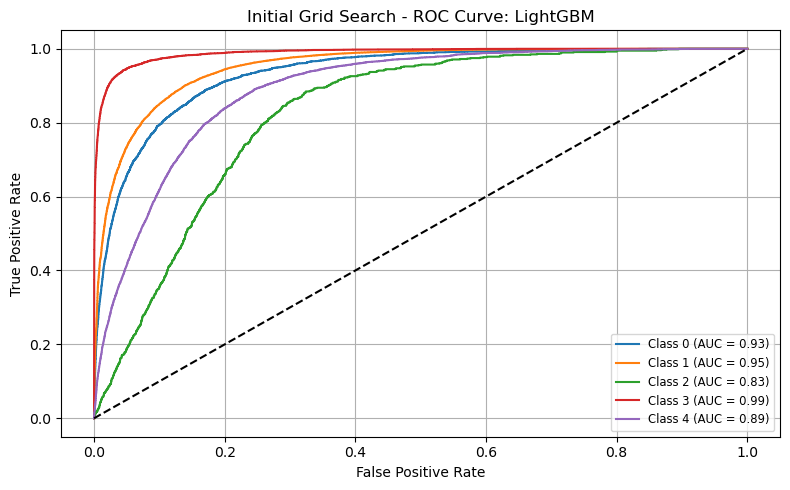

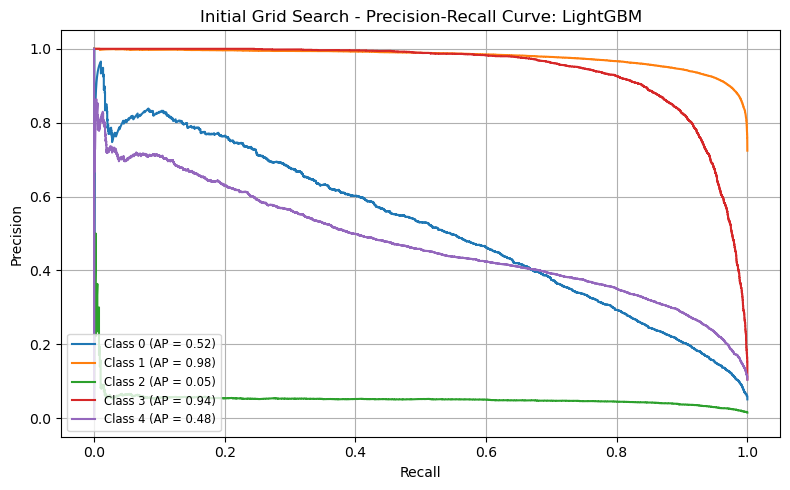

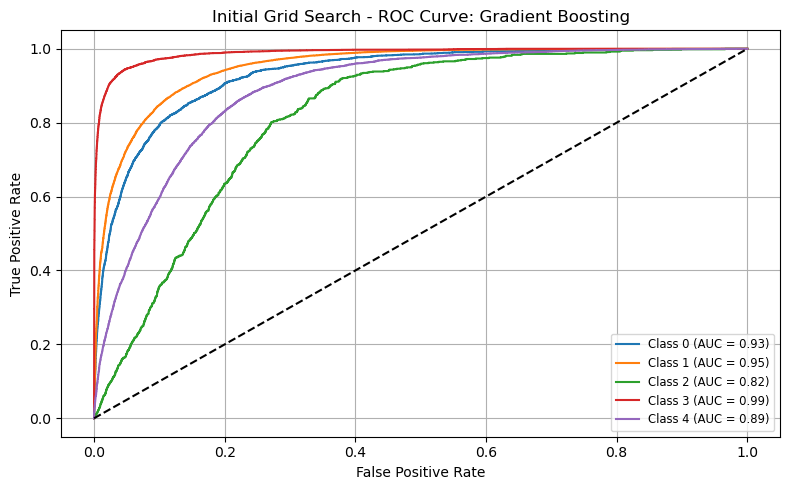

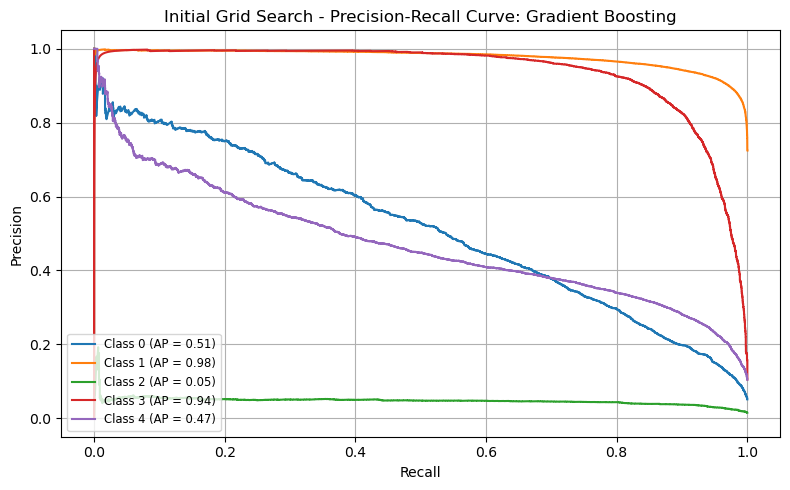

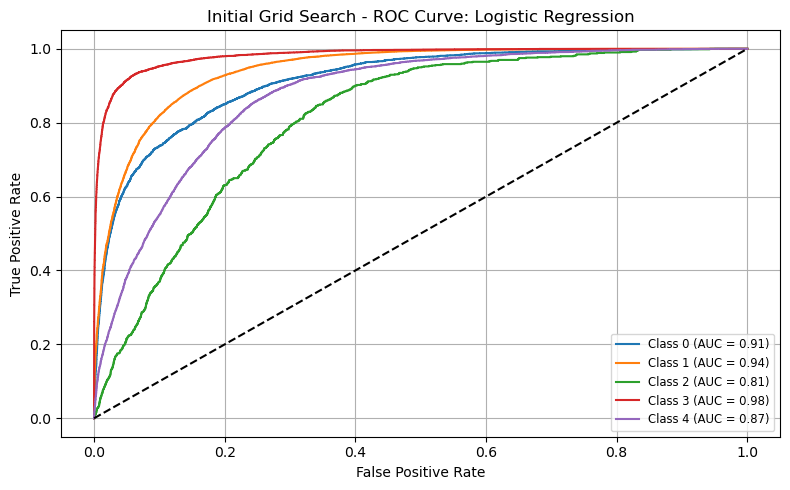

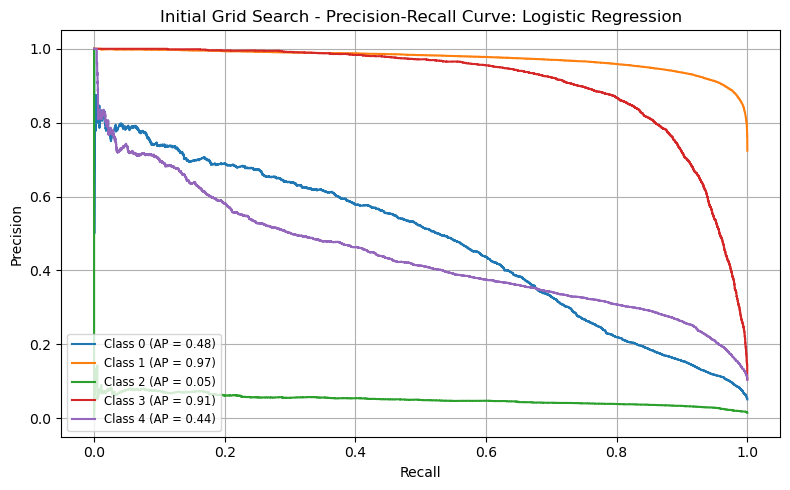

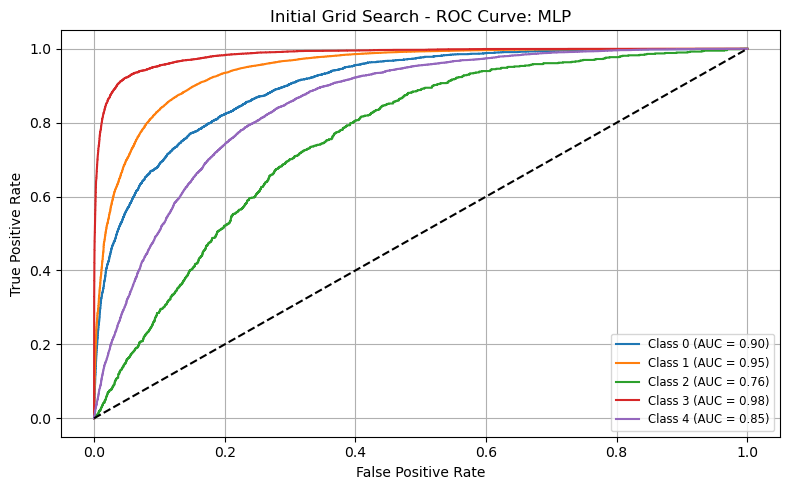

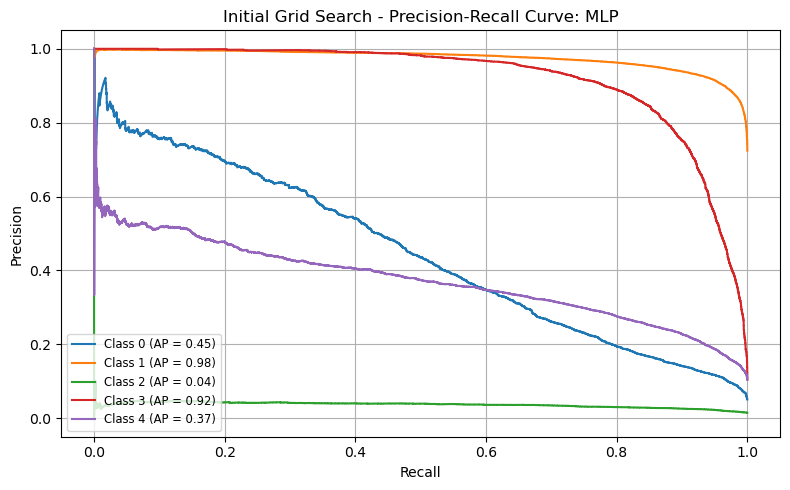

In [115]:
plot_roc_pr_curves(
    model_dict=trained_models,  # or all_models
    X_test=X_test,
    y_test=y_test_multi,
    title_prefix="Initial Grid Search"
)

In [52]:
def explain_models_with_shap(models, X_train, X_test, sample_size=100, background_size=100):
    import shap
    import numpy as np
    import pandas as pd

    shap_values_main = {}
    X_test_sample = X_test.sample(sample_size, random_state=42)
    background = shap.sample(X_train, background_size, random_state=42)

    for model_name, model in models.items():
        print(f"\nSHAP for: {model_name}")
        try:
            # === Tree-based models with TreeExplainer ===
            if model_name.lower().startswith(("xgboost", "lightgbm", "random forest")):
                # Use model-specific booster when possible
                explainer = shap.TreeExplainer(model)
                shap_vals = explainer.shap_values(X_test_sample)

            # === All others use KernelExplainer ===
            else:
                explainer = shap.KernelExplainer(model.predict_proba, background)
                shap_vals = explainer.shap_values(X_test_sample)

            # Handle multiclass
            if isinstance(shap_vals, list):
                shap_vals = shap_vals[1] if len(shap_vals) > 1 else shap_vals[0]

            shap_vals_main = shap_vals[:, :, 1] if shap_vals.ndim == 3 else shap_vals

            if shap_vals_main.shape[0] != X_test_sample.shape[0]:
                print(f"Mismatch in SHAP shape for {model_name}")
                continue

            shap_values_main[model_name] = shap_vals_main
            shap.summary_plot(shap_vals_main, X_test_sample, feature_names=X_train.columns, plot_type="dot", show=True)

        except Exception as e:
            print(f"SHAP failed for {model_name}: {e}")
    return shap_values_main

def plot_mean_shap_summary(shap_values_main, feature_names):

    shap_summary_df = pd.DataFrame({
        model: np.abs(values).mean(axis=0)
        for model, values in shap_values_main.items()
    }, index=feature_names).T

    mean_shap = shap_summary_df.mean(axis=0).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=mean_shap.values, y=mean_shap.index, palette="Set3")
    for rect in ax.patches:
        width = rect.get_width()
        ax.text(width + 0.001, rect.get_y() + rect.get_height() / 2, f"{width:.3f}", ha="left", va="center")
    plt.title("Mean Absolute SHAP Value (Across All Models)")
    plt.xlabel("SHAP Value")
    plt.tight_layout()
    plt.show()


SHAP for: Decision Tree


  0%|          | 0/100 [00:00<?, ?it/s]

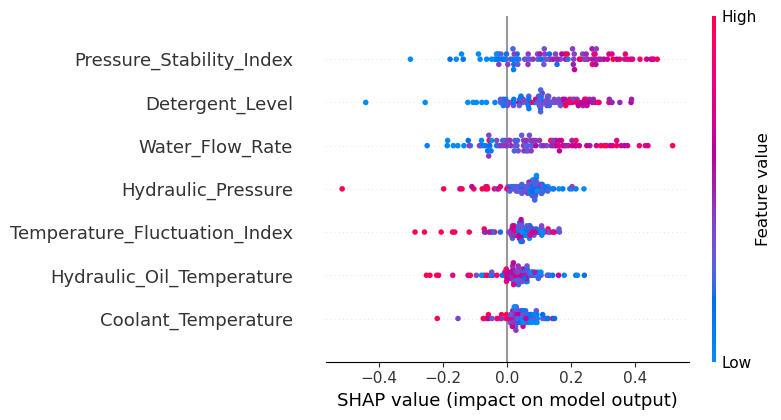


SHAP for: Random Forest


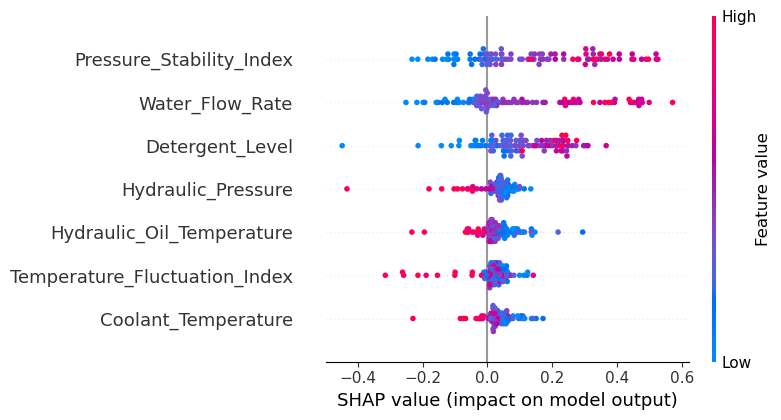


SHAP for: XGBoost


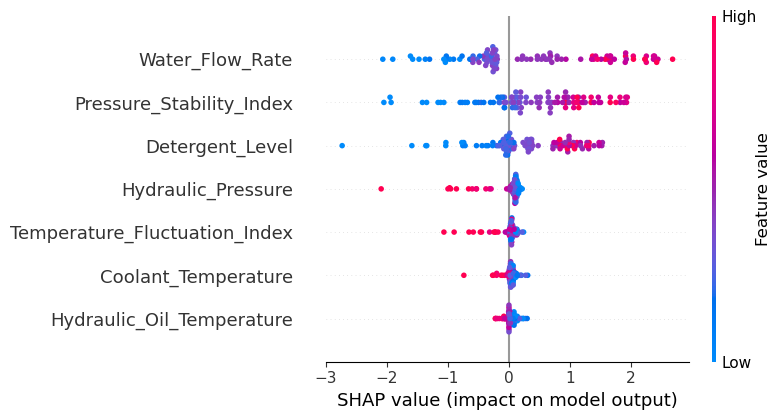


SHAP for: LightGBM


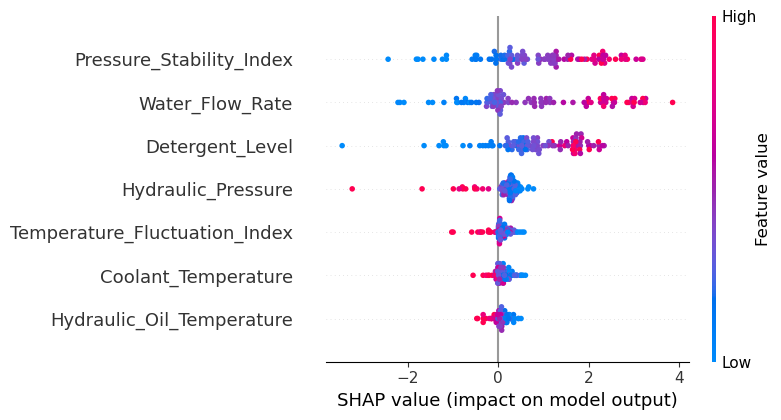


SHAP for: Gradient Boosting


  0%|          | 0/100 [00:00<?, ?it/s]

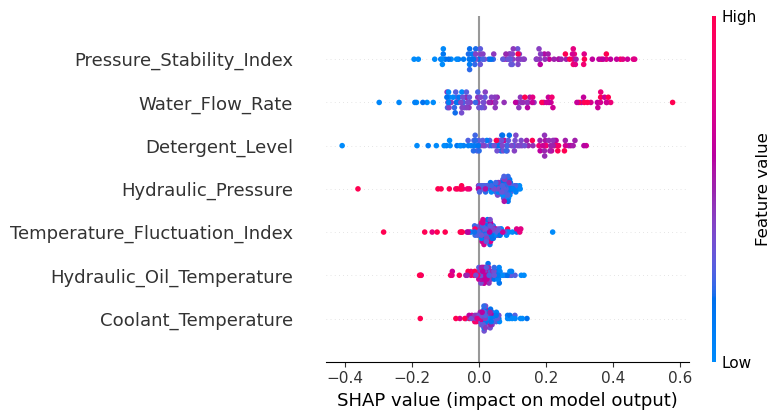


SHAP for: Logistic Regression


  0%|          | 0/100 [00:00<?, ?it/s]

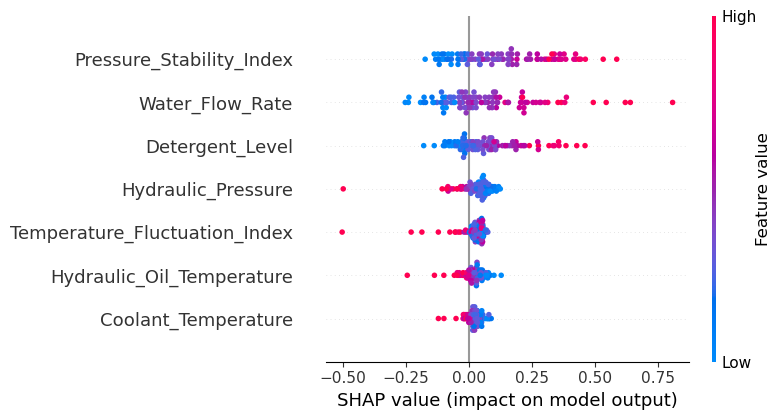


SHAP for: MLP


  0%|          | 0/100 [00:00<?, ?it/s]

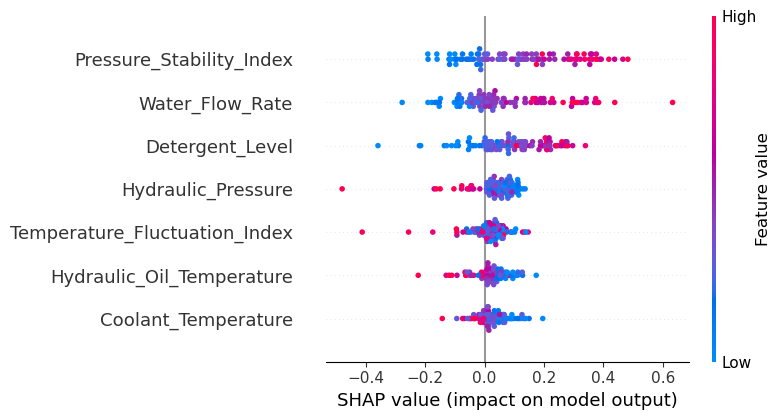

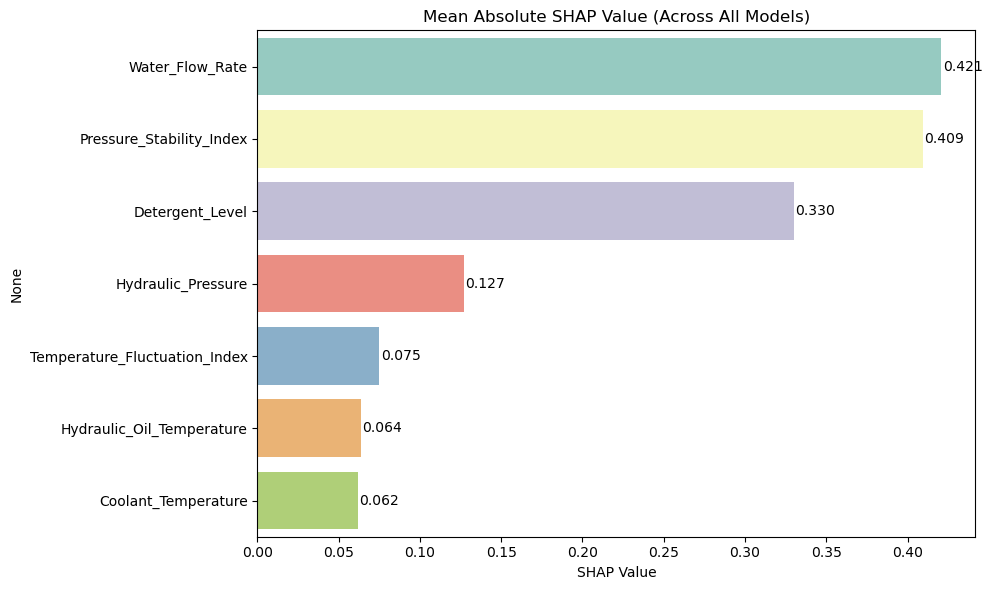

In [54]:
# Explain and plot individual SHAP summary plots
shap_values_main = explain_models_with_shap(
    models=trained_models,
    X_train=X_train_multi,
    X_test=X_test,
    sample_size=100,
    background_size=100
)

# Plot overall SHAP feature importance
plot_mean_shap_summary(
    shap_values_main=shap_values_main,
    feature_names=X_train_multi.columns
)

In [56]:
from sklearn.model_selection import learning_curve
import pandas as pd

def get_learning_curve_data(estimator, X, y, cv, scoring="f1_macro", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Returns a DataFrame with training size, train and CV scores (mean and std) for a given model.
    """
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        shuffle=True,
        random_state=42
    )

    df = pd.DataFrame({
        "Training Size": train_sizes,
        "Train Score Mean": train_scores.mean(axis=1),
        "Train Score Std": train_scores.std(axis=1),
        "CV Score Mean": cv_scores.mean(axis=1),
        "CV Score Std": cv_scores.std(axis=1)
    })

    return df

In [58]:
# Create the dictionary
learning_curve_data_dict = {}

# You can use your cv_strategy from before (e.g., StratifiedKFold)
for model_name, model in trained_models.items():
    print(f"Generating learning curve for: {model_name}")
    try:
        df_lc = get_learning_curve_data(
            estimator=model,
            X=X_train_multi,
            y=y_train_multi,
            cv=cv_strategy,
            scoring="f1_macro"
        )
        learning_curve_data_dict[model_name] = df_lc
    except Exception as e:
        print(f"Failed for {model_name}: {e}")

Generating learning curve for: Decision Tree
Generating learning curve for: Random Forest
Generating learning curve for: XGBoost
Failed for XGBoost: 'super' object has no attribute '__sklearn_tags__'
Generating learning curve for: LightGBM
Generating learning curve for: Gradient Boosting
Generating learning curve for: Logistic Regression
Generating learning curve for: MLP


In [59]:
def plot_combined_learning_curves(learning_curve_data_dict, title_prefix="Learning Curve"):
    for model_name, df in learning_curve_data_dict.items():
        if not isinstance(df, pd.DataFrame):
            continue
        x = df["Training Size"].values
        plt.figure(figsize=(10, 5))
        plt.plot(x, df["Train Score Mean"], 'o-', label="Train", color='tomato')
        plt.fill_between(x, df["Train Score Mean"] - df["Train Score Std"], df["Train Score Mean"] + df["Train Score Std"], alpha=0.1, color='tomato')
        plt.plot(x, df["CV Score Mean"], 's--', label="CV", color='seagreen')
        plt.fill_between(x, df["CV Score Mean"] - df["CV Score Std"], df["CV Score Mean"] + df["CV Score Std"], alpha=0.1, color='seagreen')
        plt.title(f"{title_prefix} - {model_name}")
        plt.xlabel("Training Examples")
        plt.ylabel("F1 Score")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

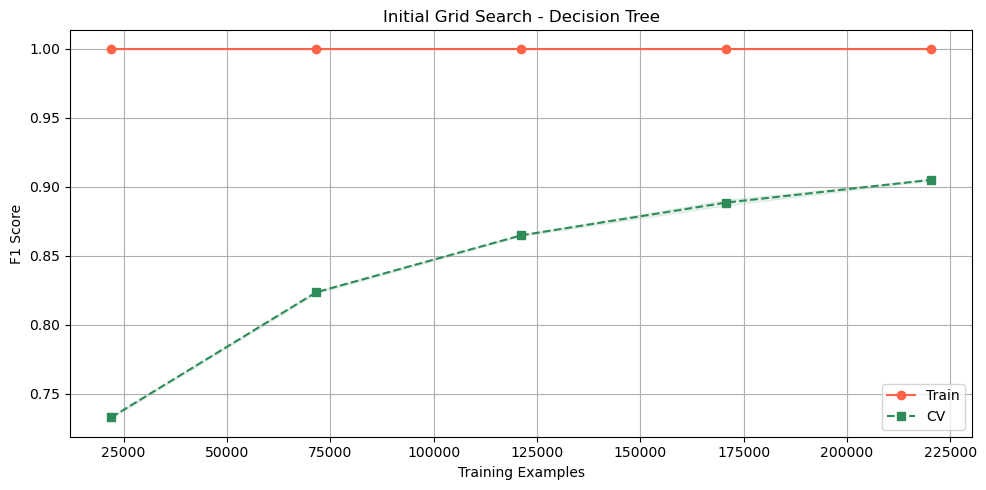

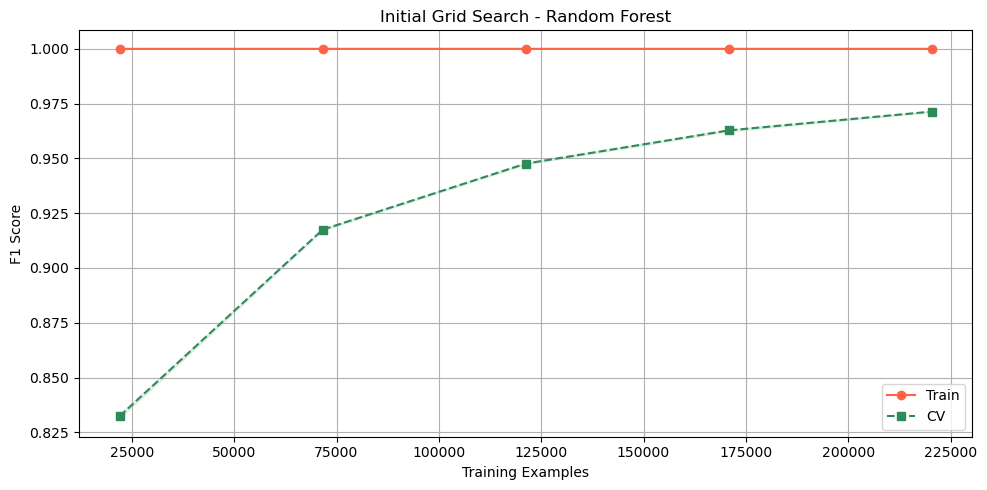

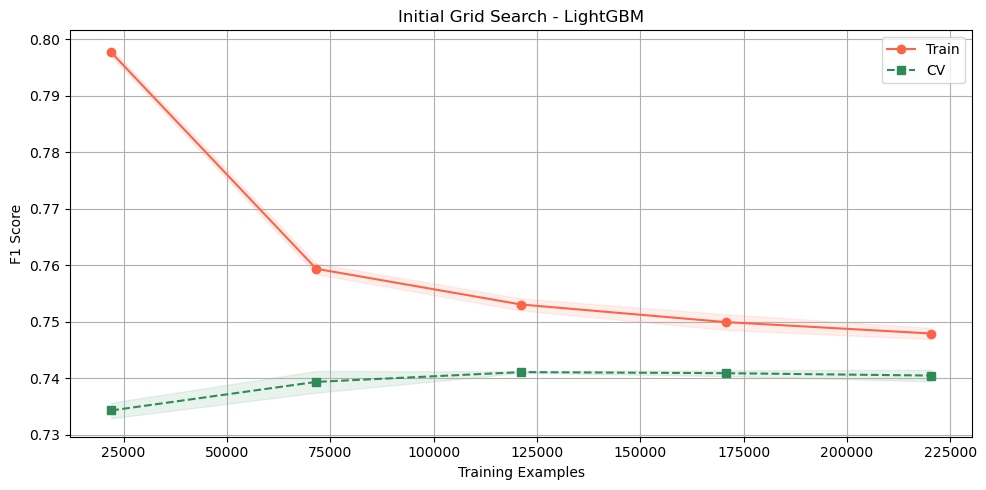

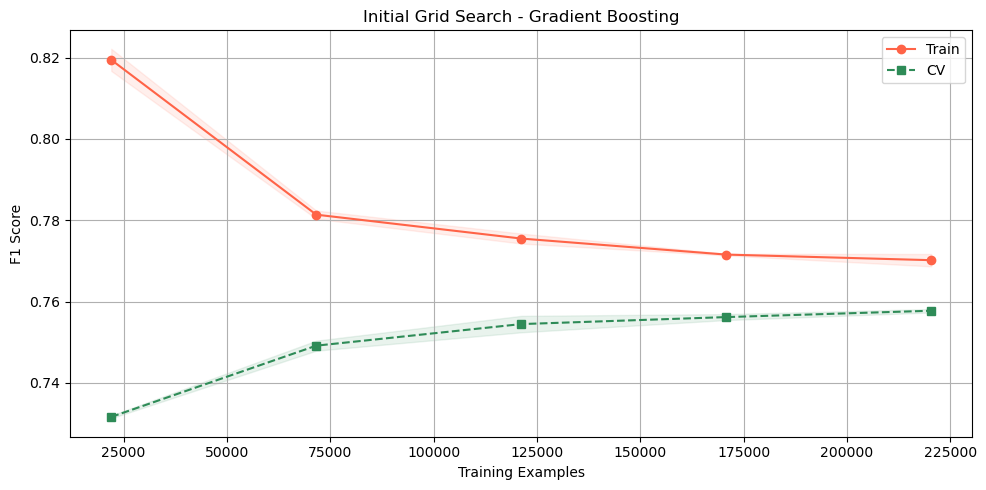

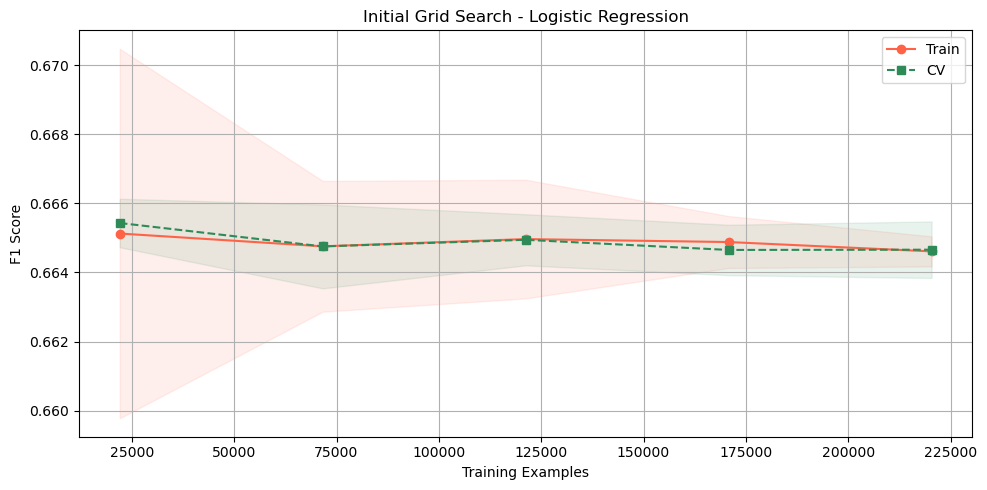

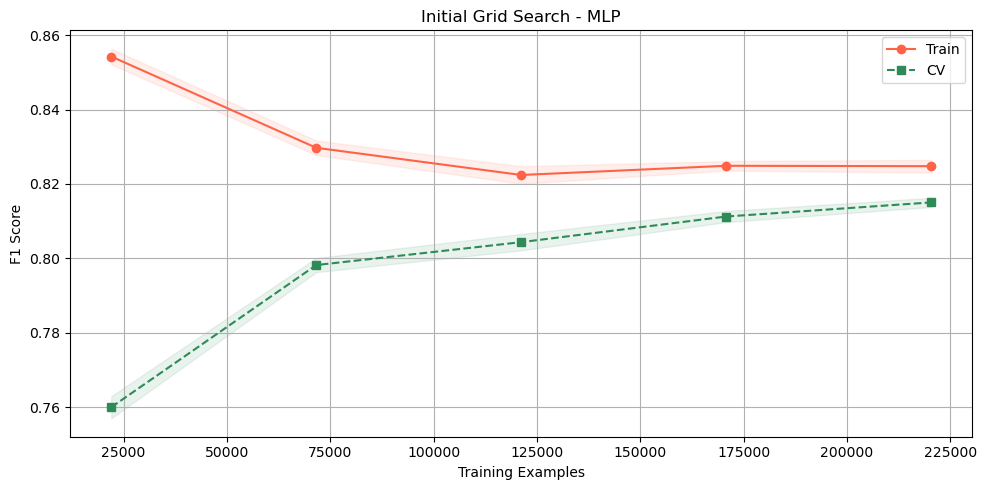

In [60]:
plot_combined_learning_curves(
    learning_curve_data_dict=learning_curve_data_dict,
    title_prefix="Initial Grid Search"
)

In [67]:
regularised_models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=10, ccp_alpha=0.01, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=5, min_samples_split=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, objective="multi:softprob", num_class=5, use_label_encoder=False, eval_metric="mlogloss", verbosity=0, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, objective="multiclass", num_class=5, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=42),
    "Logistic Regression": LogisticRegression(C=0.05, penalty="l2", multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(50, 50), activation="tanh", alpha=0.01, learning_rate_init=0.001, max_iter=300, early_stopping=True, random_state=42)
}

fine_tune_grids = {
    "Decision Tree": {
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10],
        "min_samples_split": [2, 5],
    },
    "XGBoost": {
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.05, 0.1],
    },
    "LightGBM": {
        "n_estimators": [50, 100],
        "max_depth": [5, 10],
        "learning_rate": [0.05, 0.1],
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.05, 0.1],
    },
    "Logistic Regression": {
        "C": [0.1, 1.0, 10],
        "penalty": ["l2"]
    },
    "MLP": {
        "hidden_layer_sizes": [(50,), (50, 50)],
        "activation": ["relu", "tanh"],
        "learning_rate_init": [0.001, 0.01]
    }
}

In [87]:
# Drop Coolant_Temperature from training and test sets
X_train_multi_dropped = X_train_multi.drop(columns=["Coolant_Temperature"])
X_test_dropped = X_test.drop(columns=["Coolant_Temperature"])

In [93]:
# Save the dropped feature datasets to CSV
X_train_multi_dropped.to_csv(r"C:\Users\ghaza\Desktop\FYP\Application\AI\data\dropped_final_training\X_train_multi_dropped.csv", index=False)
X_test_dropped.to_csv(r"C:\Users\ghaza\Desktop\FYP\Application\AI\data\dropped_final_training\X_test_multi_dropped.csv", index=False)

print("Files saved successfully.")


Files saved successfully.


In [150]:
from itertools import product
import pandas as pd
import numpy as np
from sklearn.base import clone, is_classifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

def safe_cross_val_score(estimator, X, y, cv, scoring):
    try:
        if not is_classifier(estimator):
            return np.array([np.nan])
        return cross_val_score(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    except Exception as e:
        print(f"Cross-validation failed: {e}")
        return np.array([np.nan])

In [162]:
def evaluate_pipeline_multiclass_with_manual_tuning(
    regularised_models, fine_tune_grids, X_train, y_train, X_test, y_test, cv_folds=5
):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    all_models = {}
    reg_results, ft_results = {}, {}
    cm_dict_reg, cm_dict_ft = {}, {}

    def print_summary(name, model, X_train, y_train, X_test, y_test, best_params, fit_status, auc_pr, auc_roc, mcc, specificity):
        y_pred = model.predict(X_test)
        print(f"\nStarting grid search for {name}...")
        print(classification_report(y_test, y_pred))
        print(f"\nResults for {name}:")
        results = {
            "Best Parameters": best_params,
            "Train Accuracy": accuracy_score(y_train, model.predict(X_train)),
            "Test Accuracy": accuracy_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred, average="macro"),
            "AUC-PR": auc_pr,
            "AUC-ROC": auc_roc,
            "MCC": mcc,
            "Specificity": specificity,
            "Fit Status": fit_status
        }
        for k, v in results.items():
            print(f"{k}: {v}")
        print("-" * 80)

    for model_name, base_model in regularised_models.items():
        print(f"\nProcessing {model_name}...")

        # === REGULARISED ===
        reg_model = clone(base_model)
        reg_model.fit(X_train, y_train)

        cv_scores = safe_cross_val_score(reg_model, X_train, y_train, cv=cv, scoring="f1_macro")
        y_train_pred = reg_model.predict(X_train)
        y_test_pred = reg_model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        fit_status = (
            "Potential Overfitting Detected!" if train_acc > test_acc + 0.1 else
            "Potential Underfitting Detected!" if test_acc > train_acc + 0.1 else
            "Balanced Performance"
        )

        auc_roc = auc_pr = None
        if hasattr(reg_model, "predict_proba"):
            try:
                y_probs = reg_model.predict_proba(X_test)
                auc_roc = roc_auc_score(y_test, y_probs, multi_class="ovr")
                auc_pr = np.mean([
                    auc(*precision_recall_curve((y_test == i).astype(int), y_probs[:, i])[1::-1])
                    for i in np.unique(y_test)
                ])
            except Exception:
                pass

        cm = confusion_matrix(y_test, y_test_pred)
        specificity = cm[0, 0] / np.sum(cm[0]) if cm.shape[0] > 1 else None
        cm_dict_reg[model_name] = cm

        reg_results[model_name] = {
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "F1-Macro": f1_score(y_test, y_test_pred, average="macro"),
            "Precision": precision_score(y_test, y_test_pred, average="macro"),
            "Recall": recall_score(y_test, y_test_pred, average="macro"),
            "MCC": matthews_corrcoef(y_test, y_test_pred),
            "AUC-PR": auc_pr,
            "AUC-ROC": auc_roc,
            "Specificity": specificity,
            "CV F1 Mean": np.nanmean(cv_scores),
            "CV F1 Std": np.nanstd(cv_scores),
            "Fit Status": fit_status
        }

        all_models[f"{model_name} - Regularised"] = reg_model

        print_summary(
            name=model_name + " (Regularised)",
            model=reg_model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            best_params=reg_model.get_params(),
            fit_status=fit_status,
            auc_pr=auc_pr,
            auc_roc=auc_roc,
            mcc=matthews_corrcoef(y_test, y_test_pred),
            specificity=specificity
        )

        # === CONDITIONAL TUNING ===
        if model_name in ["XGBoost", "Gradient Boosting", "LightGBM"]:
            print(f"Manually tuning {model_name}...")
            best_score = -np.inf
            best_model = None
            best_params = None

            for combo in product(*fine_tune_grids[model_name].values()):
                params = dict(zip(fine_tune_grids[model_name].keys(), combo))
                try:
                    tuned_model = clone(base_model).set_params(**params)
                    tuned_model.fit(X_train, y_train)
                    preds = tuned_model.predict(X_test)
                    score = f1_score(y_test, preds, average="macro")
                    if score > best_score:
                        best_score = score
                        best_model = tuned_model
                        best_params = params
                except Exception as e:
                    print(f"Skipping {params} due to error: {e}")

        else:
            print(f"Fine-tuning {model_name} using HalvingGridSearchCV...")
            halving_grid = HalvingGridSearchCV(
                estimator=clone(base_model),
                param_grid=fine_tune_grids[model_name],
                scoring="f1_macro",
                cv=cv,
                n_jobs=-1,
                factor=2,
                verbose=0
            )
            halving_grid.fit(X_train, y_train)
            best_model = halving_grid.best_estimator_
            best_params = halving_grid.best_params_

        y_train_ft = best_model.predict(X_train)
        y_test_ft = best_model.predict(X_test)
        train_acc_ft = accuracy_score(y_train, y_train_ft)
        test_acc_ft = accuracy_score(y_test, y_test_ft)
        fit_status_ft = (
            "Potential Overfitting Detected!" if train_acc_ft > test_acc_ft + 0.1 else
            "Potential Underfitting Detected!" if test_acc_ft > train_acc_ft + 0.1 else
            "Balanced Performance"
        )

        auc_roc_ft = auc_pr_ft = None
        if hasattr(best_model, "predict_proba"):
            try:
                y_probs_ft = best_model.predict_proba(X_test)
                auc_roc_ft = roc_auc_score(y_test, y_probs_ft, multi_class="ovr")
                auc_pr_ft = np.mean([
                    auc(*precision_recall_curve((y_test == i).astype(int), y_probs_ft[:, i])[1::-1])
                    for i in np.unique(y_test)
                ])
            except Exception:
                pass

        cm_ft = confusion_matrix(y_test, y_test_ft)
        specificity_ft = cm_ft[0, 0] / cm_ft[0].sum() if cm_ft.shape[0] > 1 else None
        cm_dict_ft[model_name] = cm_ft

        ft_results[model_name] = {
            "Best Params": best_params,
            "Train Accuracy": train_acc_ft,
            "Test Accuracy": test_acc_ft,
            "F1-Macro": f1_score(y_test, y_test_ft, average="macro"),
            "Precision": precision_score(y_test, y_test_ft, average="macro"),
            "Recall": recall_score(y_test, y_test_ft, average="macro"),
            "MCC": matthews_corrcoef(y_test, y_test_ft),
            "AUC-PR": auc_pr_ft,
            "AUC-ROC": auc_roc_ft,
            "CV F1 Mean": np.nan,
            "CV F1 Std": np.nan,
            "Fit Status": fit_status_ft
        }

        all_models[f"{model_name} - FineTuned"] = best_model

        print_summary(
            name=model_name + " (Fine-Tuned)",
            model=best_model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            best_params=best_params,
            fit_status=fit_status_ft,
            auc_pr=auc_pr_ft,
            auc_roc=auc_roc_ft,
            mcc=matthews_corrcoef(y_test, y_test_ft),
            specificity=specificity_ft
        )

    df_reg = pd.DataFrame(reg_results).T
    df_ft = pd.DataFrame(ft_results).T

    print("\nSummary - Regularised Models:\n", df_reg)
    print("\nSummary - Fine-Tuned Models:\n", df_ft)

    return all_models, reg_results, ft_results, df_reg, df_ft, cm_dict_reg, cm_dict_ft

In [164]:
all_models, reg_results, ft_results, df_reg, df_ft, cm_dict_reg, cm_dict_ft = evaluate_pipeline_multiclass_with_manual_tuning(
    regularised_models=regularised_models,
    fine_tune_grids=fine_tune_grids,
    X_train=X_train_multi_dropped,
    y_train=y_train_multi,
    X_test=X_test_dropped,
    y_test=y_test_multi
)


Processing Decision Tree...

Starting grid search for Decision Tree (Regularised)...
              precision    recall  f1-score   support

           0       0.41      0.61      0.49      2683
           1       0.94      0.66      0.78     38015
           2       0.04      0.64      0.07       797
           3       0.64      0.70      0.67      5512
           4       0.50      0.19      0.27      5480

    accuracy                           0.61     52487
   macro avg       0.51      0.56      0.46     52487
weighted avg       0.83      0.61      0.69     52487


Results for Decision Tree (Regularised):
Best Parameters: {'ccp_alpha': 0.01, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Train Accuracy: 0.6192233691114365
Test Accuracy: 0.611618114961800

In [187]:
import os
import joblib

# Save path
export_path = r"C:\Users\ghaza\Desktop\FYP\Application\AI\models\Finetuned_Reg_Multiclass"
os.makedirs(export_path, exist_ok=True)

# Save models with clean filenames
for model_key, model in all_models.items():
    # Clean filename: lowercase, replace spaces with underscores
    filename = model_key.lower().replace(" ", "_").replace("-", "").replace("__", "_") + ".pkl"
    filepath = os.path.join(export_path, filename)
    joblib.dump(model, filepath)

print(f"Exported {len(all_models)} models to: {export_path}")


Exported 14 models to: C:\Users\ghaza\Desktop\FYP\Application\AI\models\Finetuned_Reg_Multiclass


In [167]:
df_reg.index = [f"{name} (Reg)" for name in df_reg.index]
df_ft.index = [f"{name} (Tuned)" for name in df_ft.index]
combined_df = pd.concat([df_reg, df_ft])

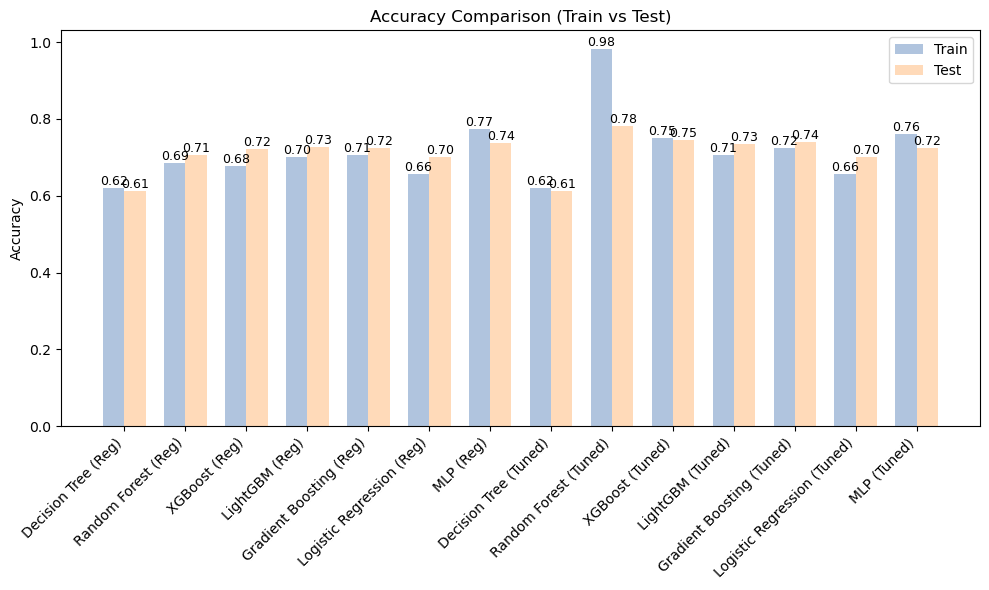

Skipping F1-Macro: missing columns.


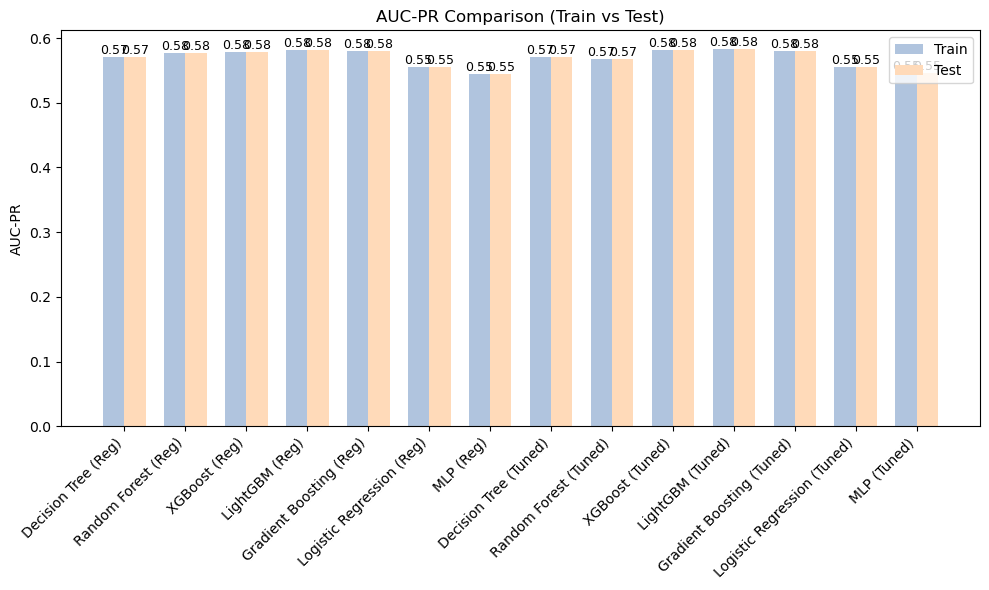

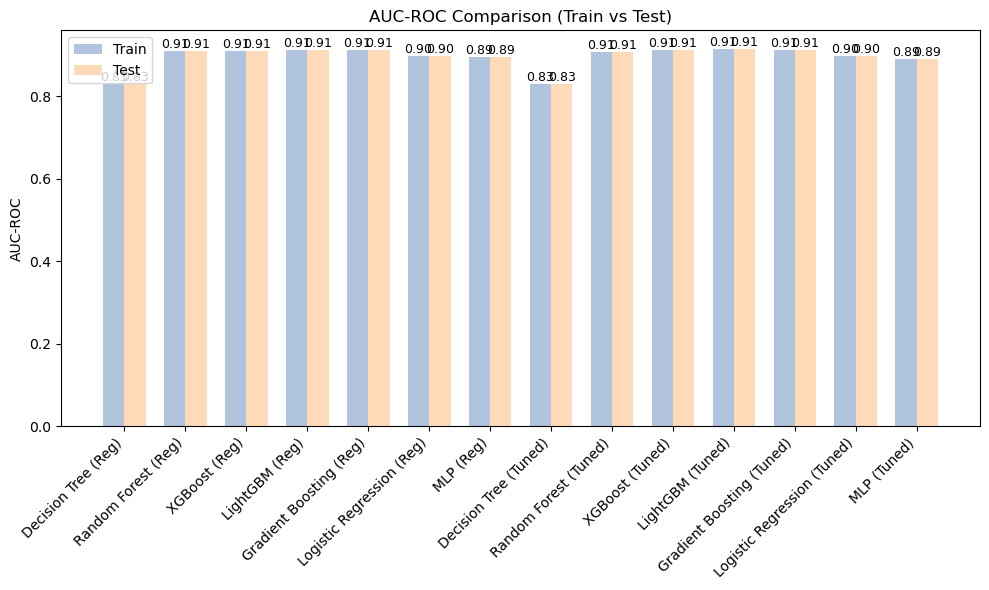

In [182]:
plot_model_metric_bars(combined_df)

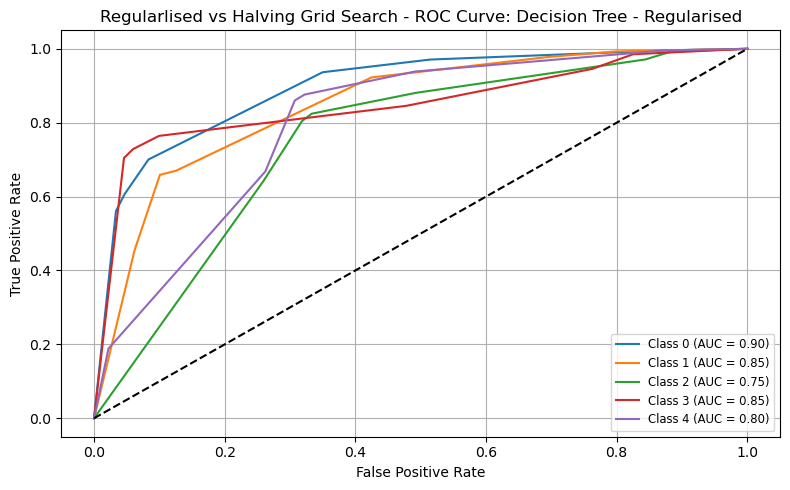

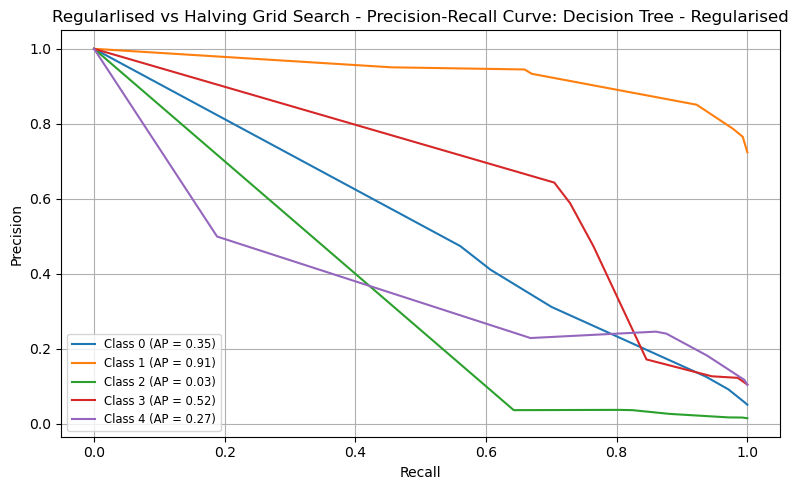

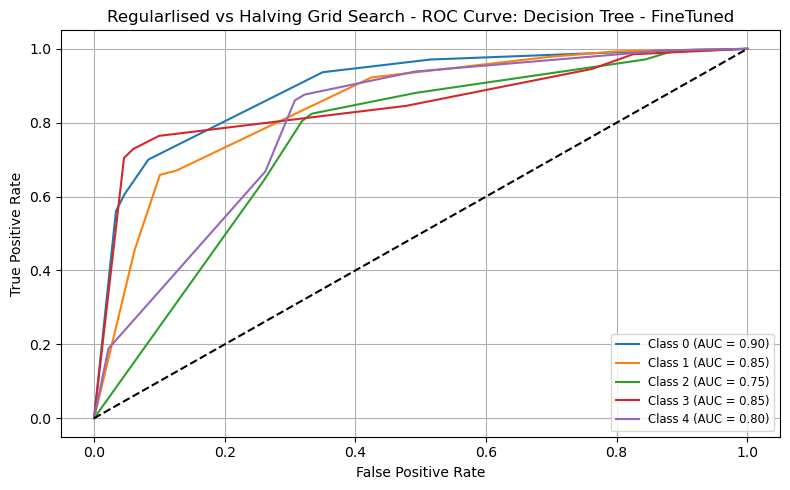

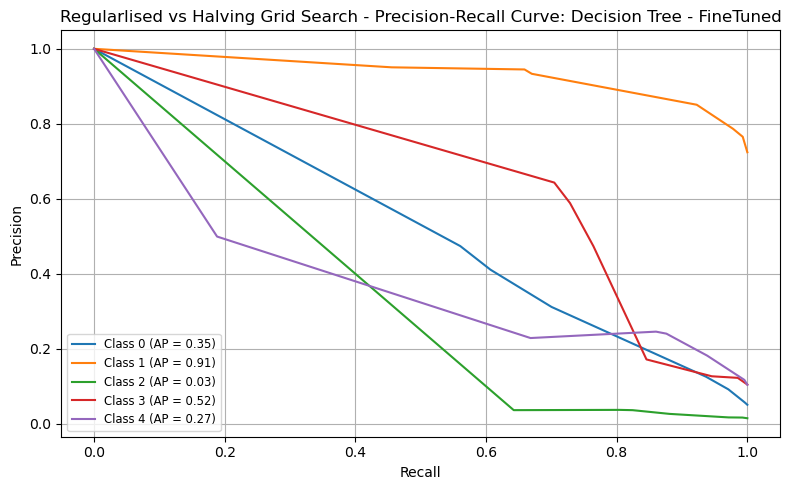

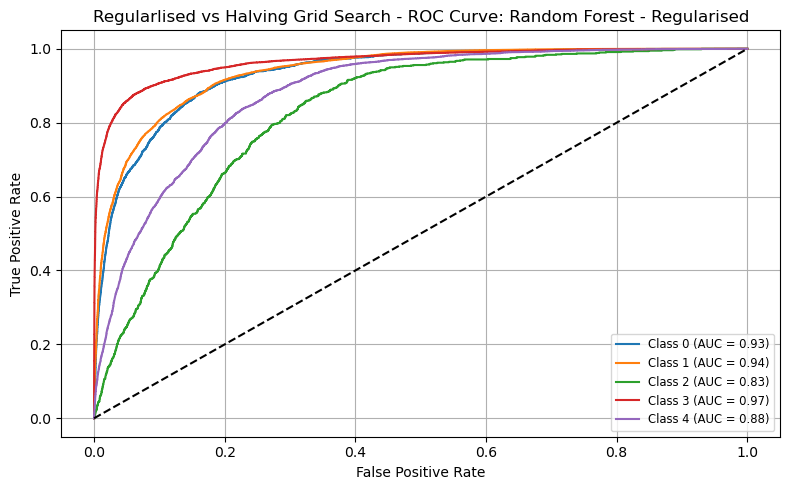

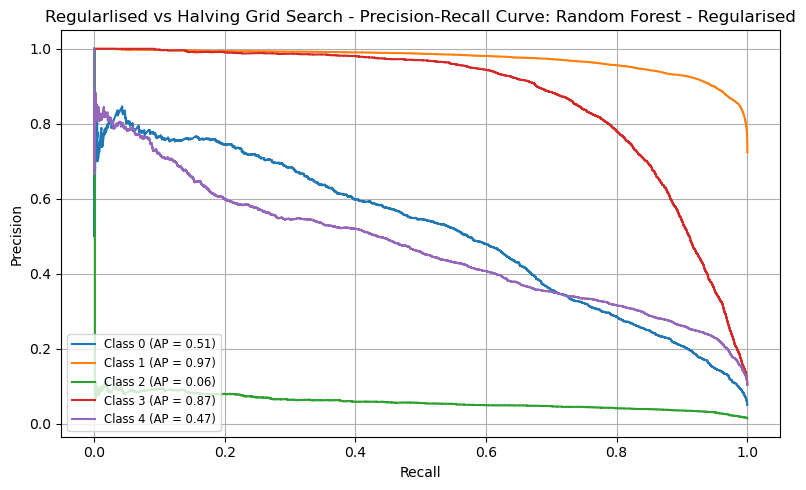

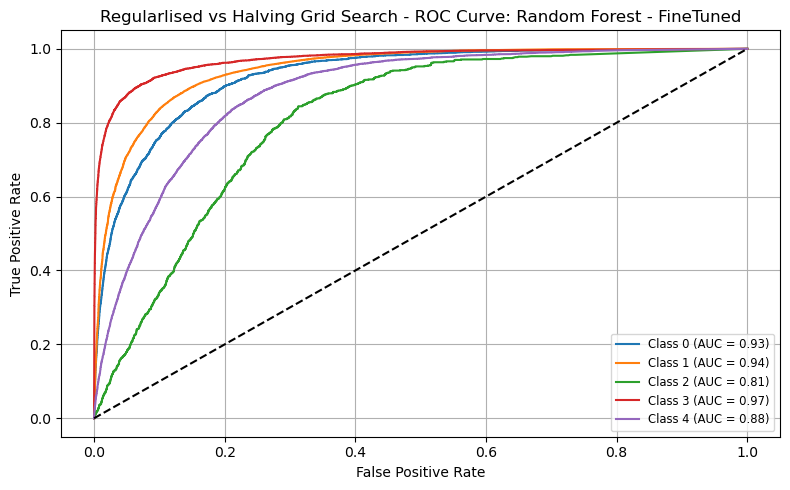

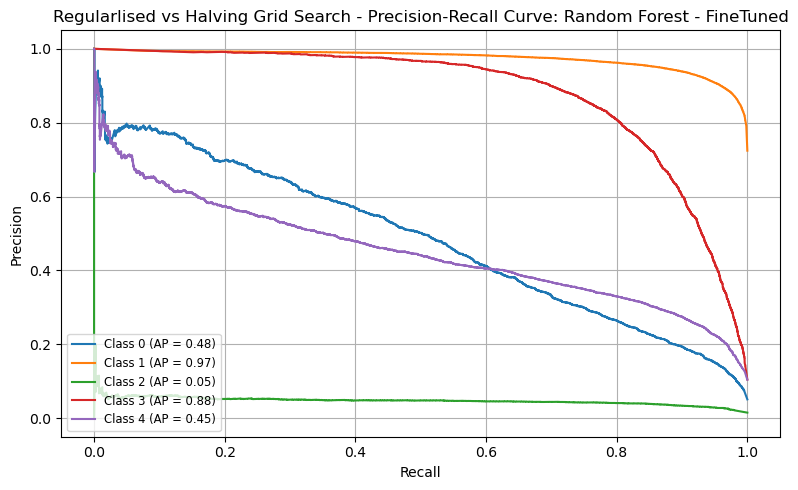

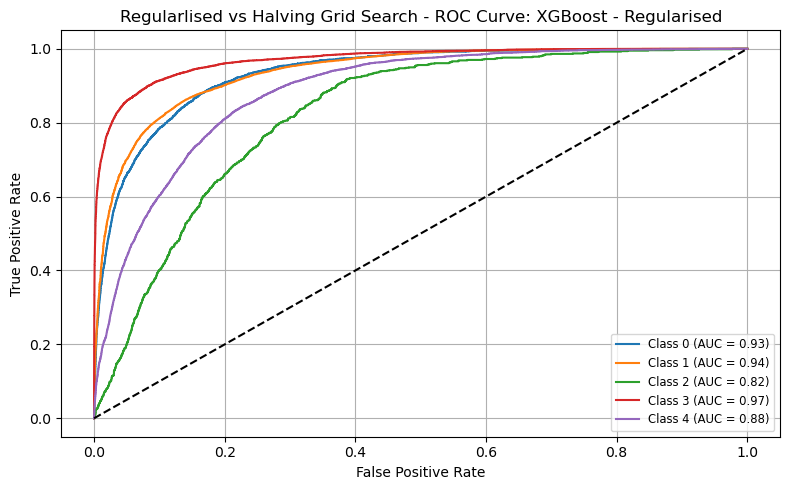

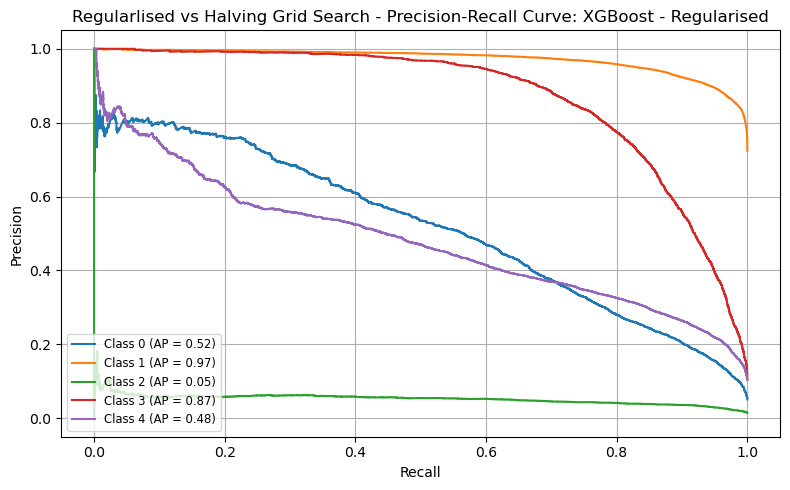

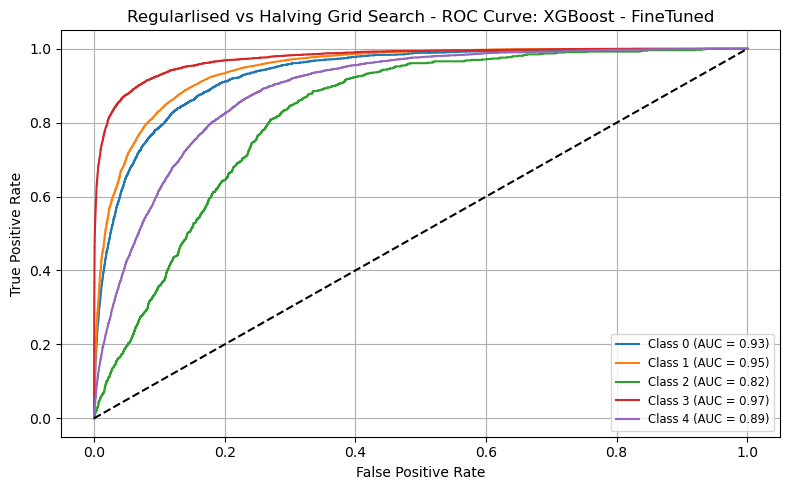

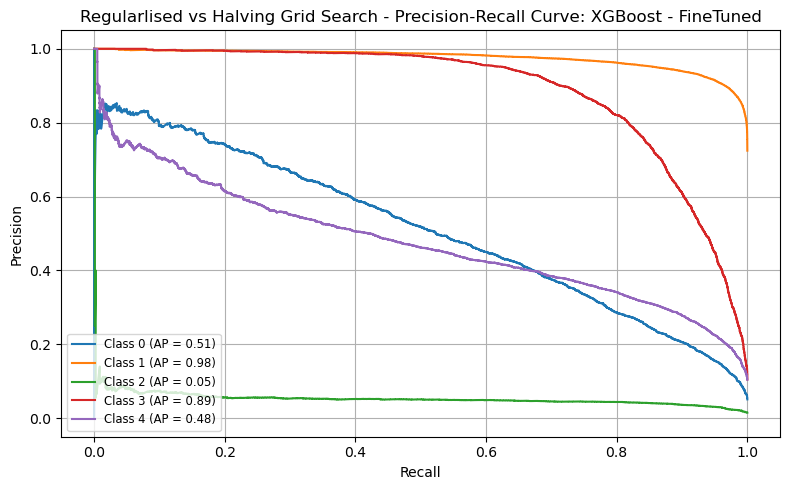

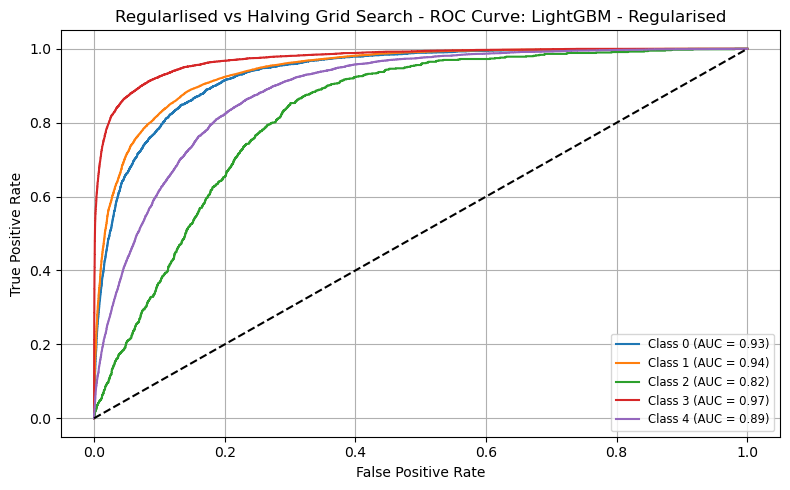

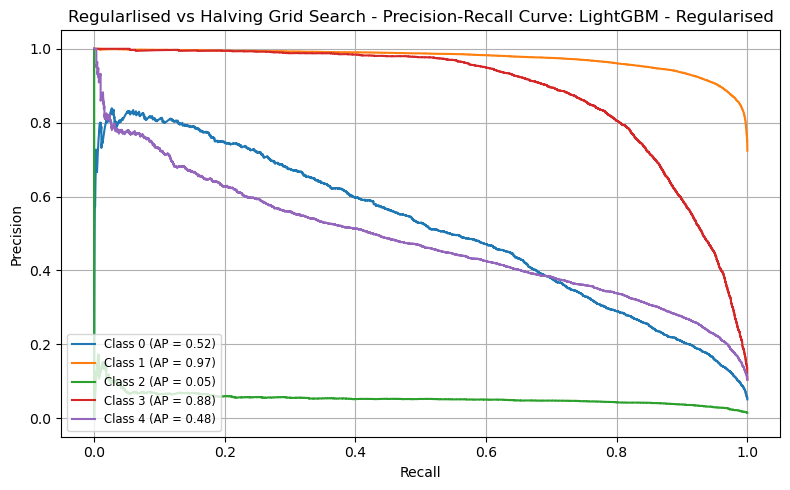

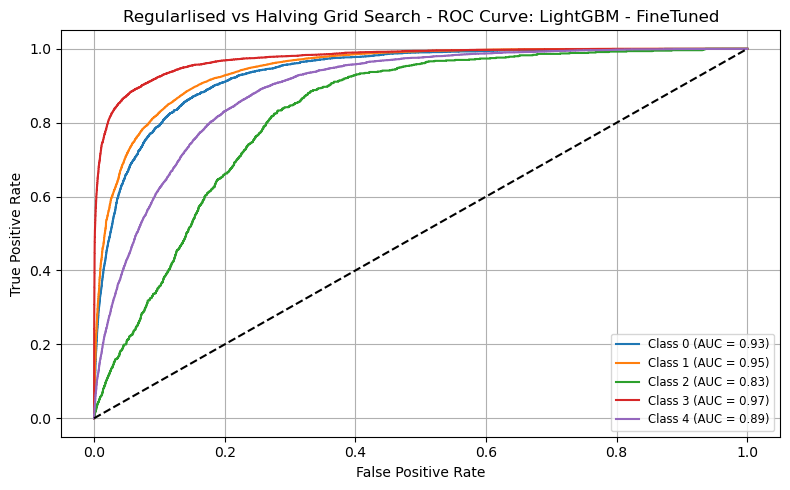

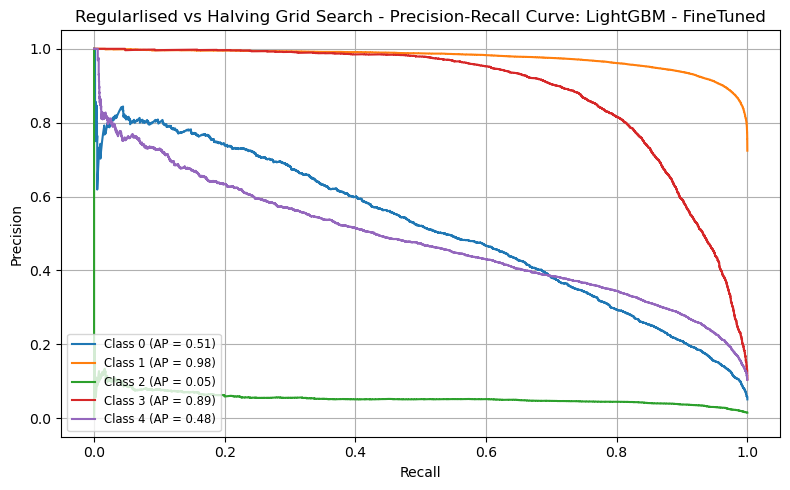

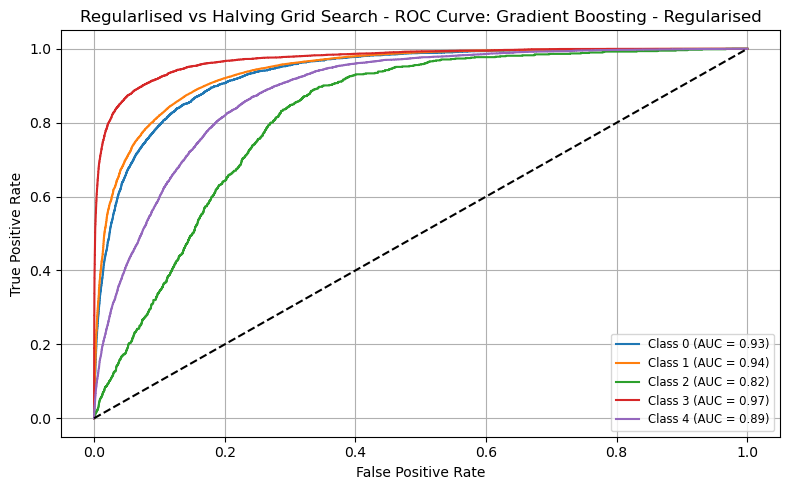

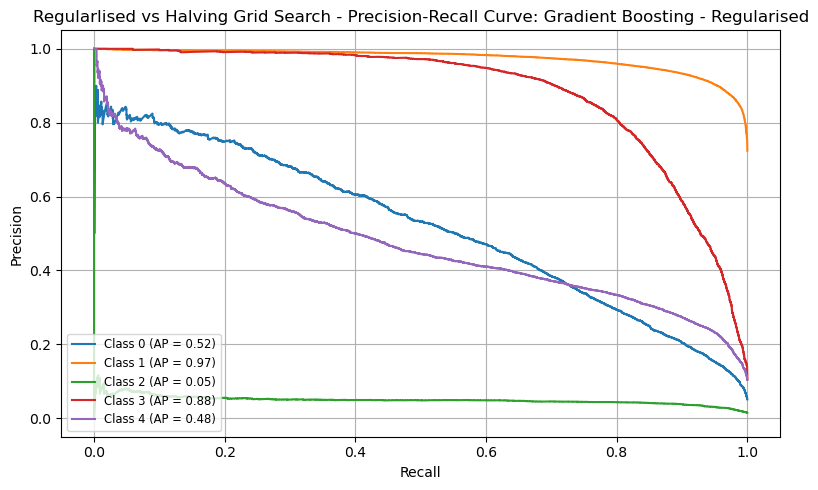

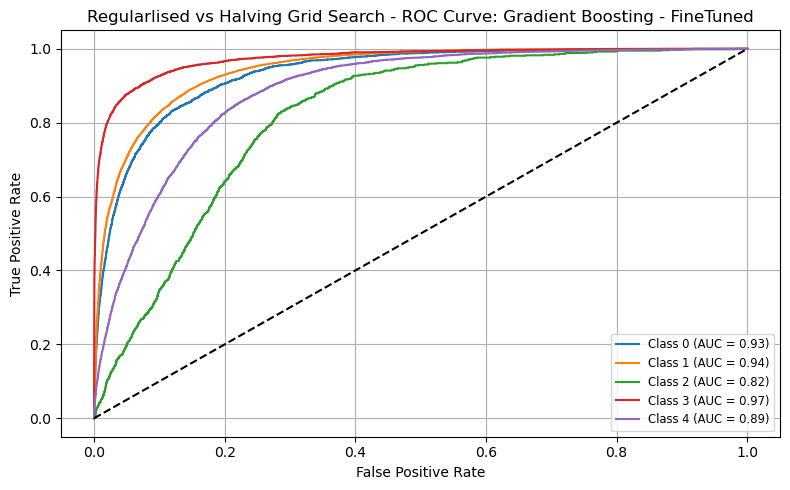

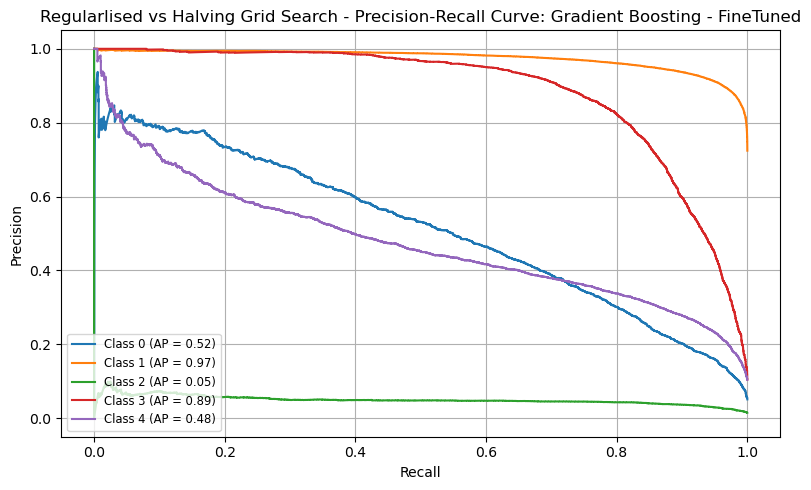

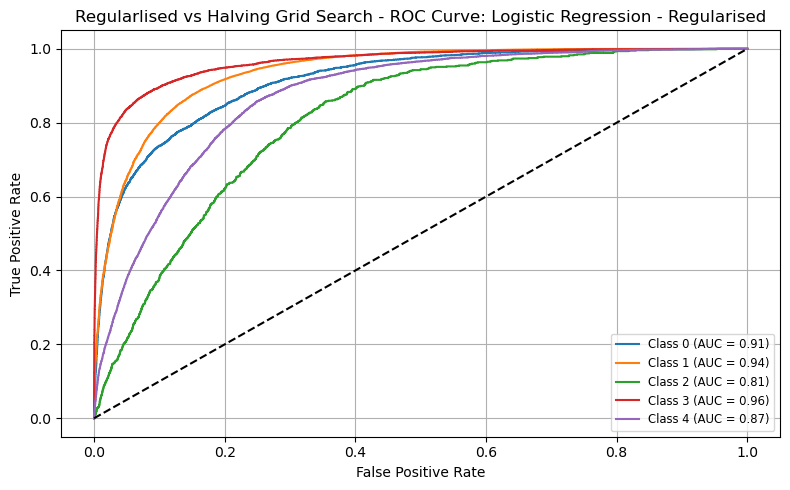

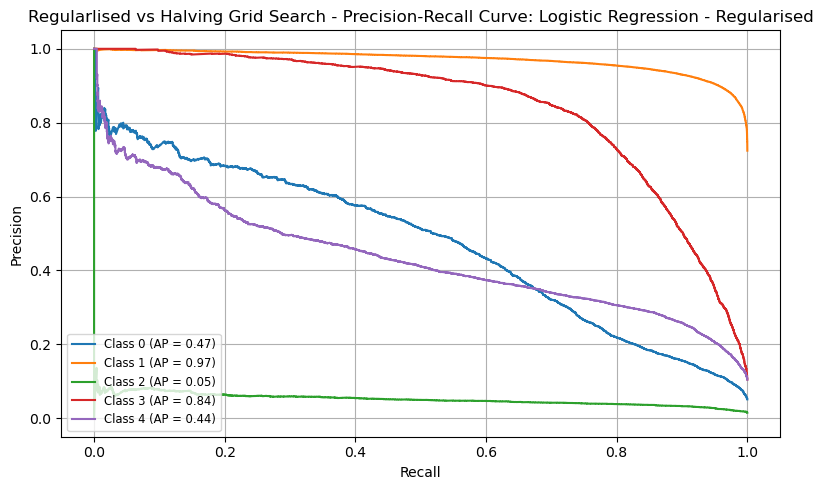

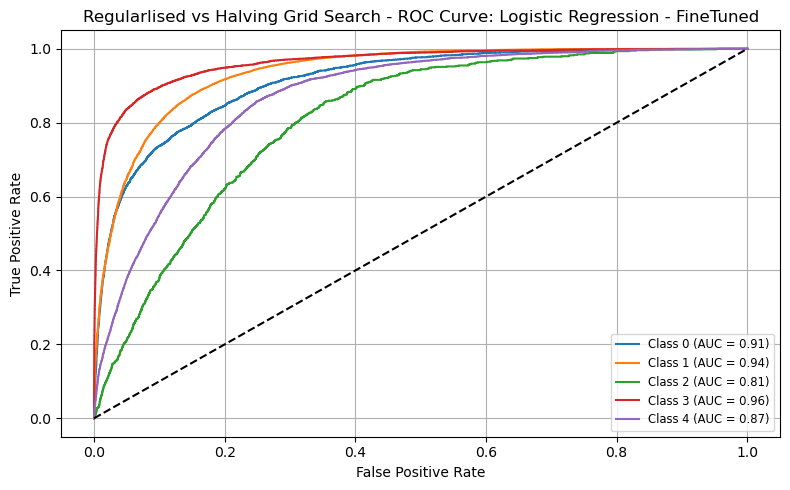

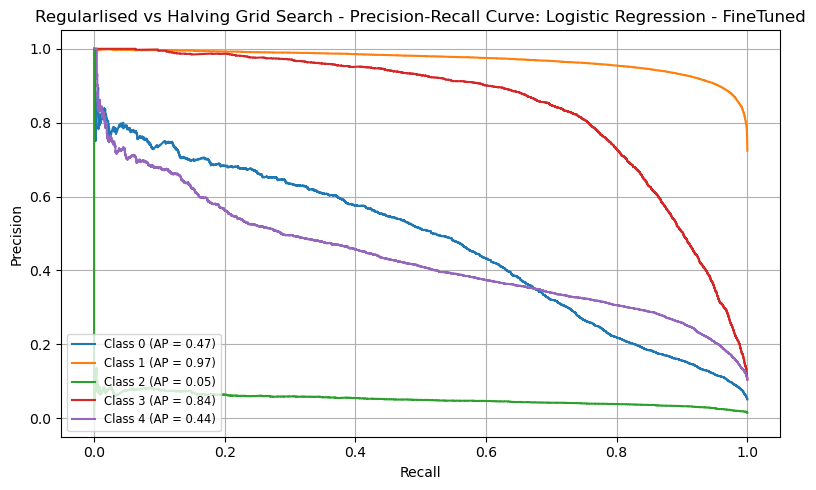

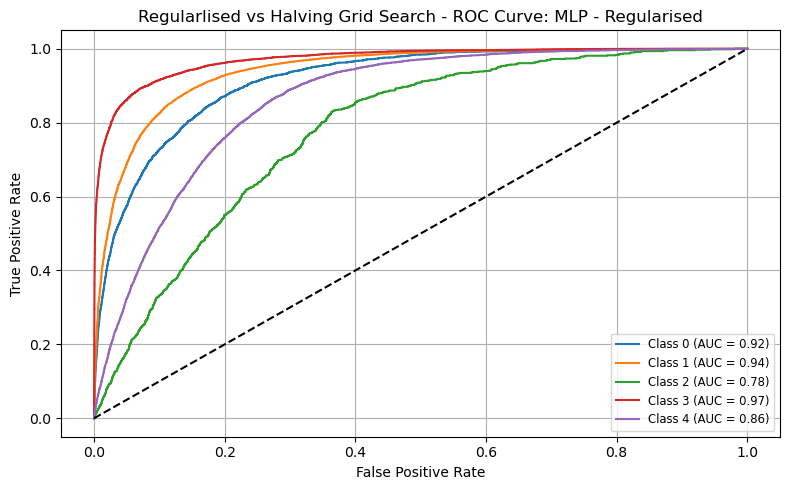

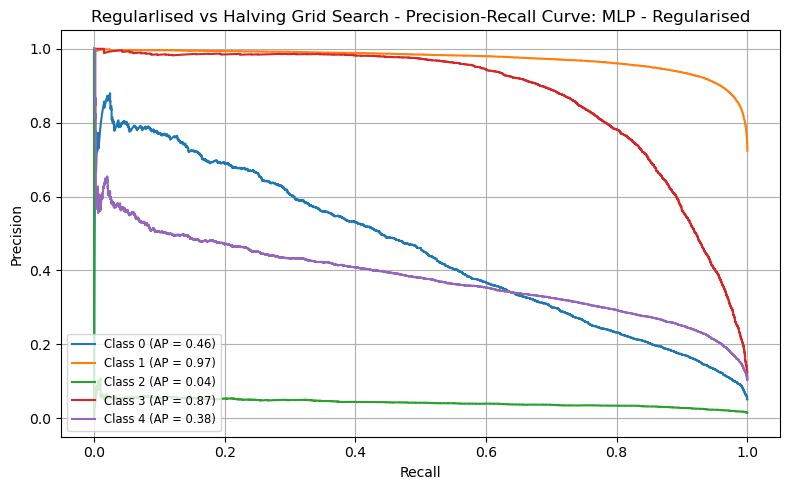

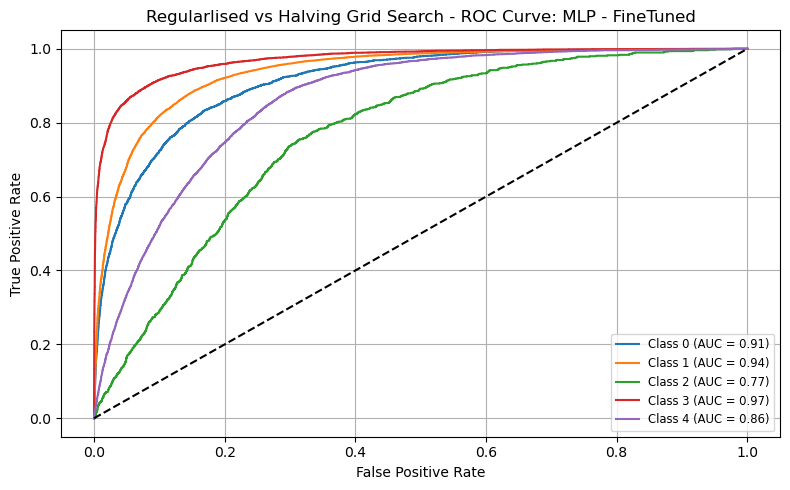

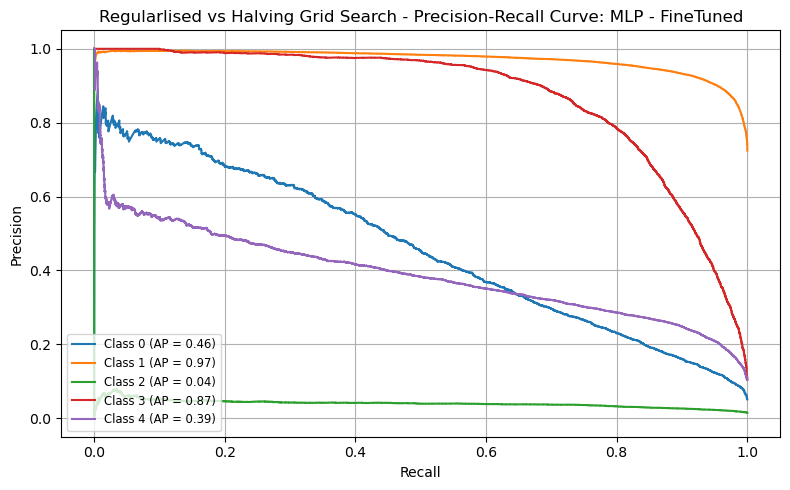

In [169]:
plot_roc_pr_curves(
    model_dict=all_models,
    X_test=X_test_dropped,
    y_test=y_test_multi,
    title_prefix="Regularlised vs Halving Grid Search"
)


SHAP for: Decision Tree - Regularised


  0%|          | 0/100 [00:00<?, ?it/s]

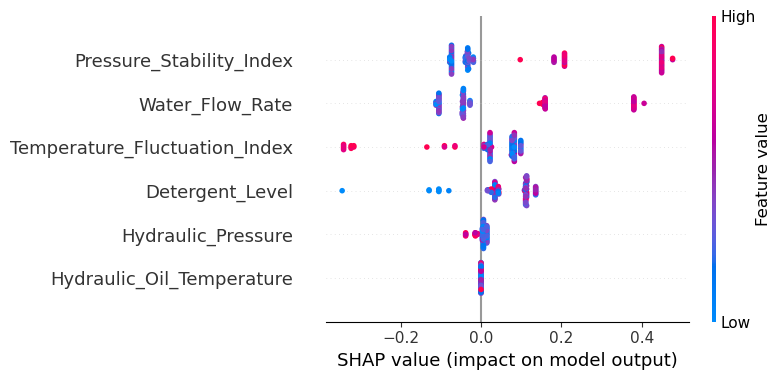


SHAP for: Decision Tree - FineTuned


  0%|          | 0/100 [00:00<?, ?it/s]

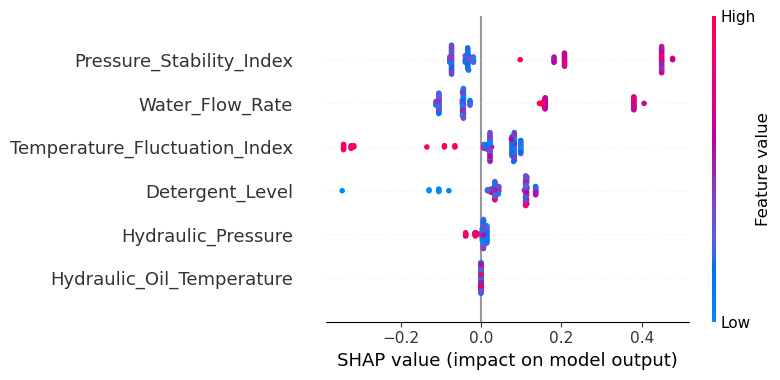


SHAP for: Random Forest - Regularised


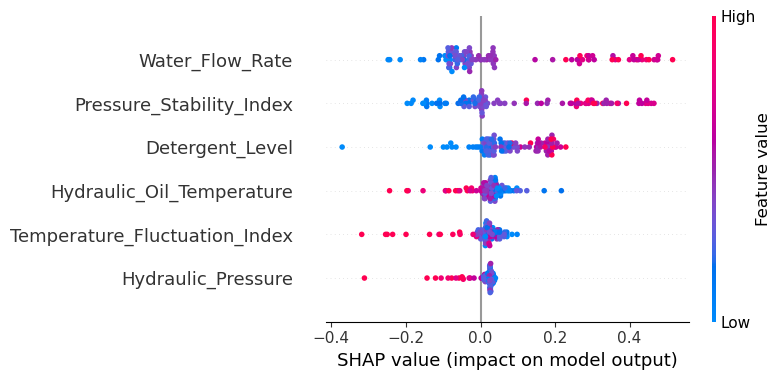


SHAP for: Random Forest - FineTuned


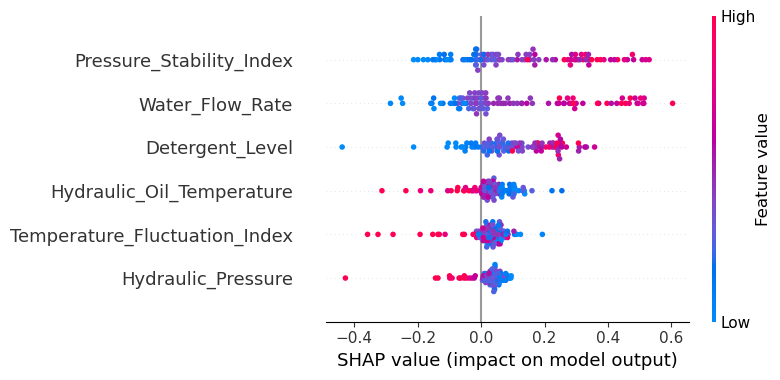


SHAP for: XGBoost - Regularised


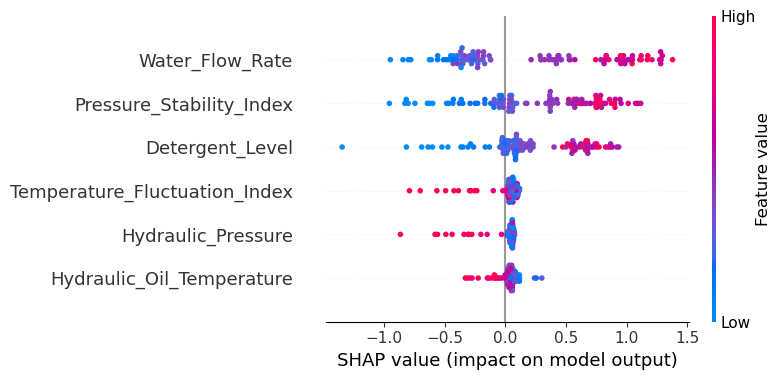


SHAP for: XGBoost - FineTuned


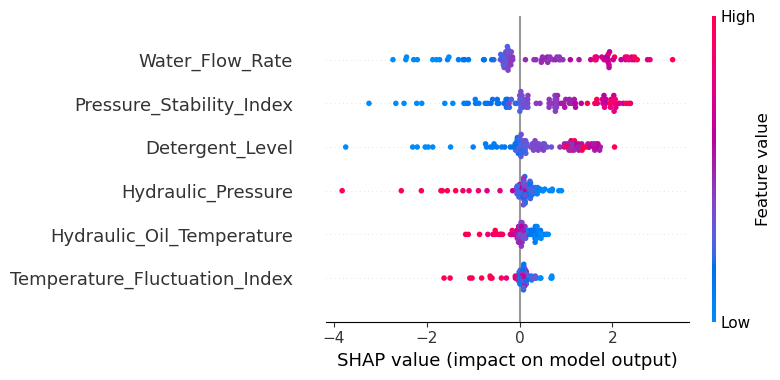


SHAP for: LightGBM - Regularised


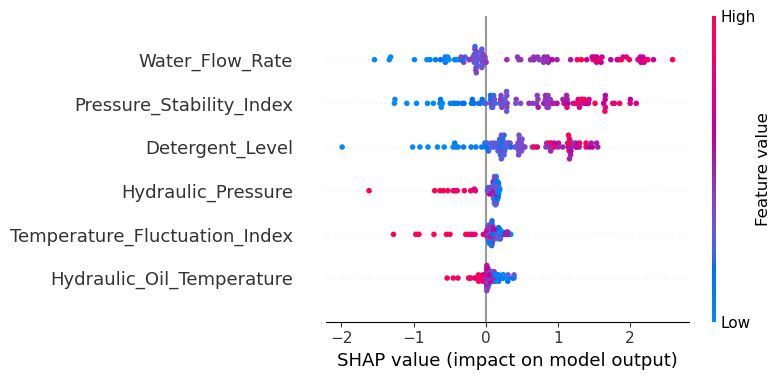


SHAP for: LightGBM - FineTuned


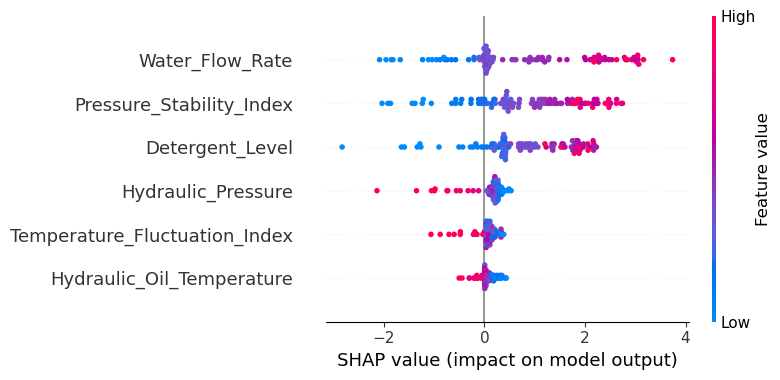


SHAP for: Gradient Boosting - Regularised


  0%|          | 0/100 [00:00<?, ?it/s]

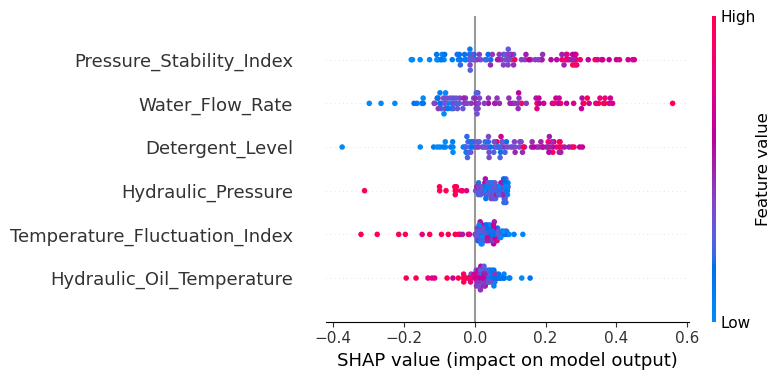


SHAP for: Gradient Boosting - FineTuned


  0%|          | 0/100 [00:00<?, ?it/s]

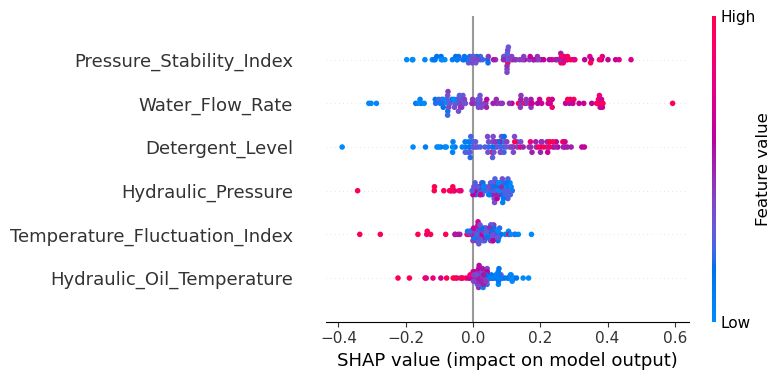


SHAP for: Logistic Regression - Regularised


  0%|          | 0/100 [00:00<?, ?it/s]

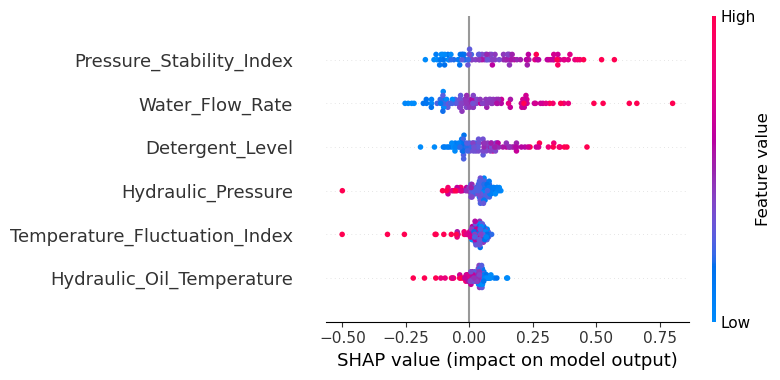


SHAP for: Logistic Regression - FineTuned


  0%|          | 0/100 [00:00<?, ?it/s]

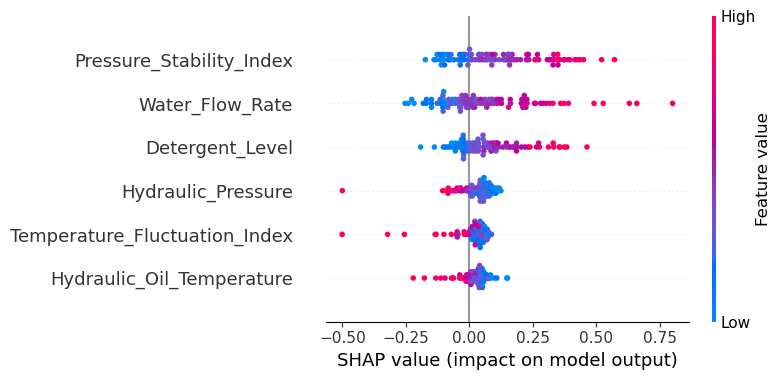


SHAP for: MLP - Regularised


  0%|          | 0/100 [00:00<?, ?it/s]

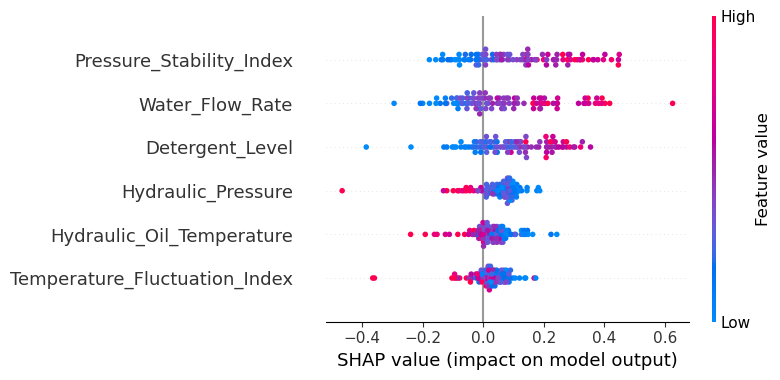


SHAP for: MLP - FineTuned


  0%|          | 0/100 [00:00<?, ?it/s]

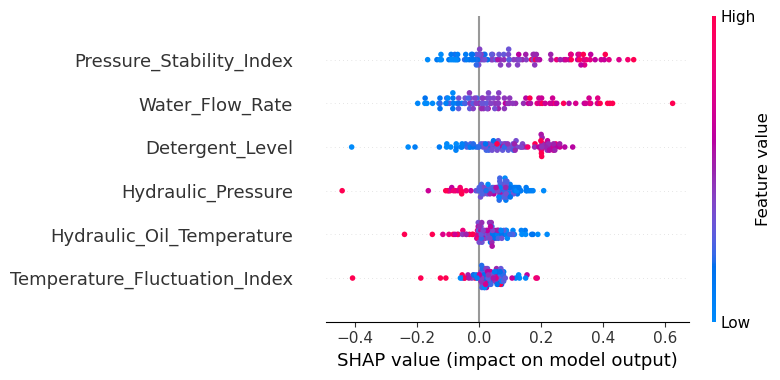

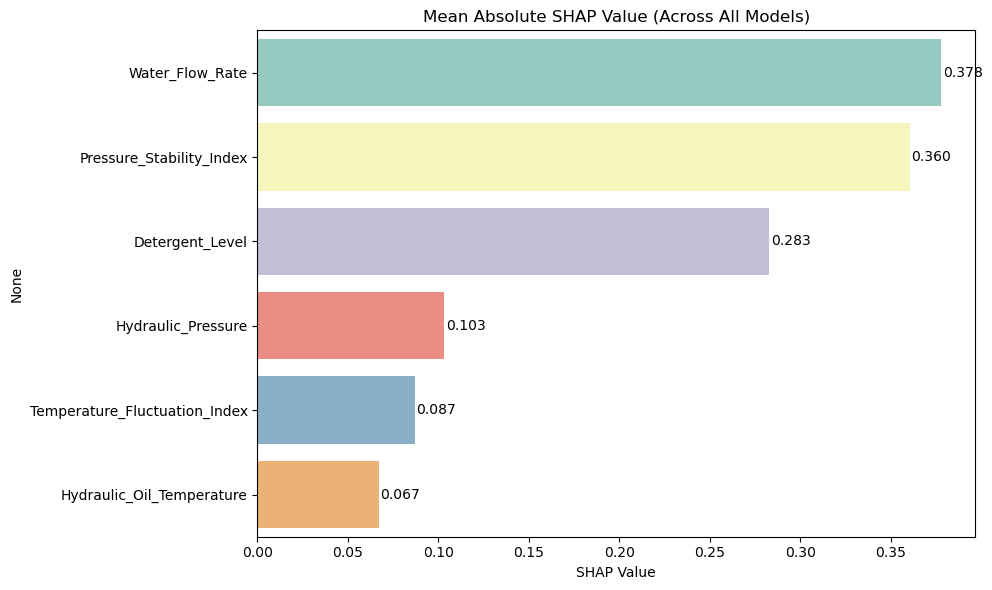

In [170]:
shap_values_main = explain_models_with_shap(
    models=all_models,
    X_train=X_train_multi_dropped,
    X_test=X_test_dropped,
    sample_size=100,
    background_size=100
)

plot_mean_shap_summary(
    shap_values_main=shap_values_main,
    feature_names=X_train_multi_dropped.columns
)

In [165]:
learning_curve_data_dict = {}

for model_name, model in all_models.items():
    print(f"Generating learning curve for: {model_name}")
    try:
        df_lc = get_learning_curve_data(
            estimator=model,
            X=X_train_multi_dropped,
            y=y_train_multi,
            cv=cv_strategy,
            scoring="f1_macro"
        )
        learning_curve_data_dict[model_name] = df_lc
    except Exception as e:
        print(f"Failed for {model_name}: {e}")

Generating learning curve for: Decision Tree - Regularised
Generating learning curve for: Decision Tree - FineTuned
Generating learning curve for: Random Forest - Regularised
Generating learning curve for: Random Forest - FineTuned
Generating learning curve for: XGBoost - Regularised
Failed for XGBoost - Regularised: 'super' object has no attribute '__sklearn_tags__'
Generating learning curve for: XGBoost - FineTuned
Failed for XGBoost - FineTuned: 'super' object has no attribute '__sklearn_tags__'
Generating learning curve for: LightGBM - Regularised
Generating learning curve for: LightGBM - FineTuned
Generating learning curve for: Gradient Boosting - Regularised
Generating learning curve for: Gradient Boosting - FineTuned
Generating learning curve for: Logistic Regression - Regularised
Generating learning curve for: Logistic Regression - FineTuned
Generating learning curve for: MLP - Regularised
Generating learning curve for: MLP - FineTuned


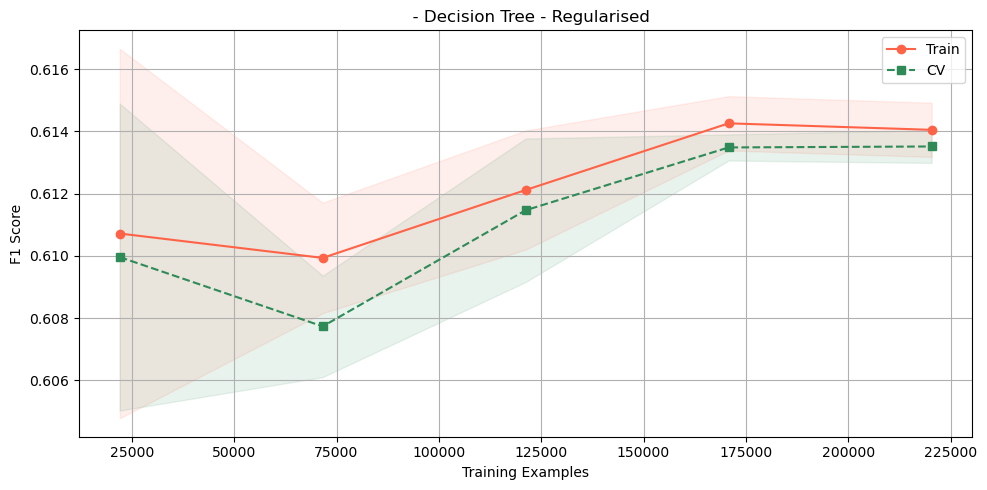

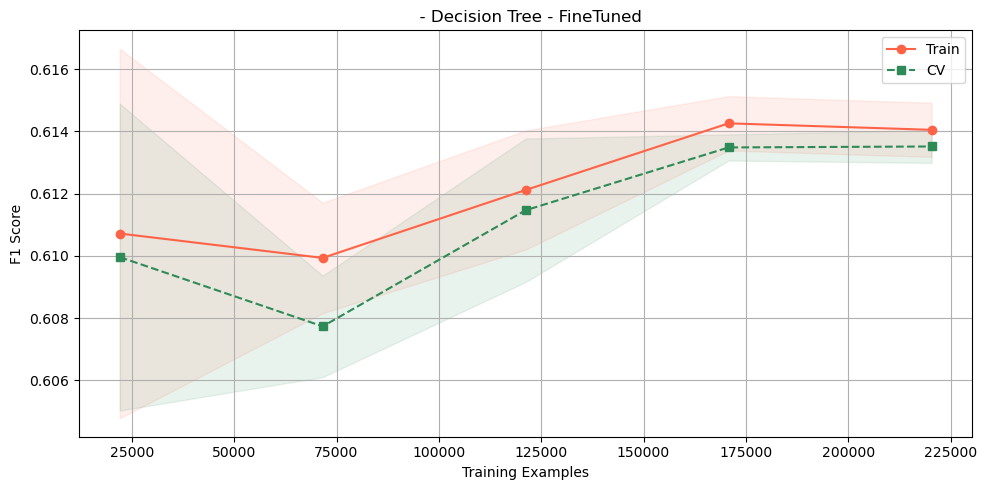

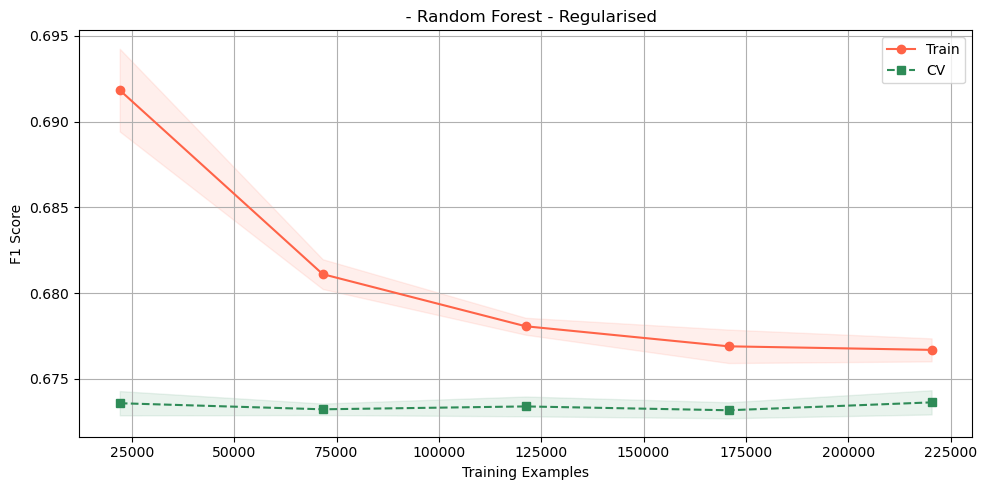

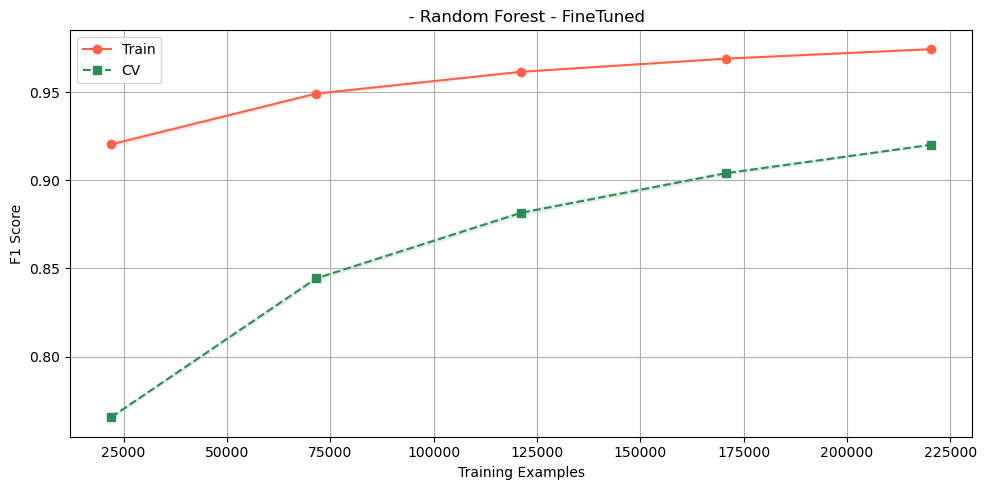

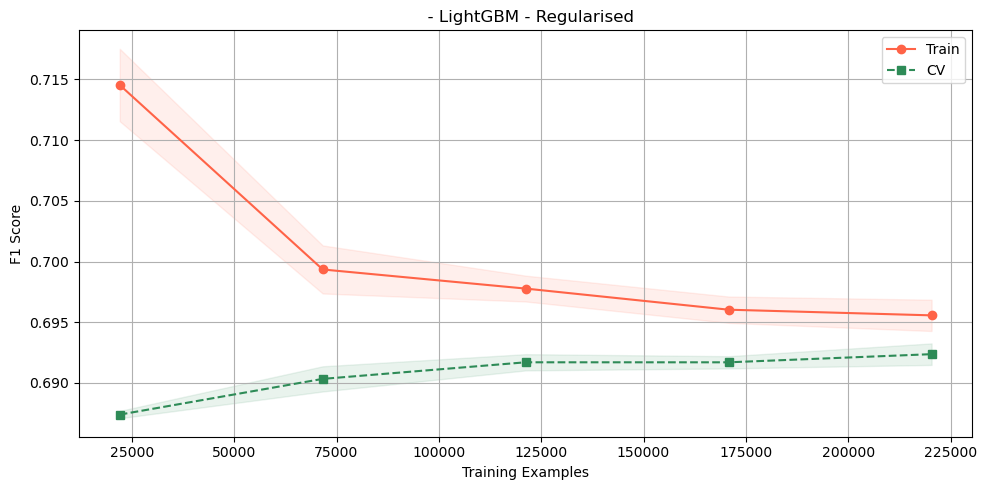

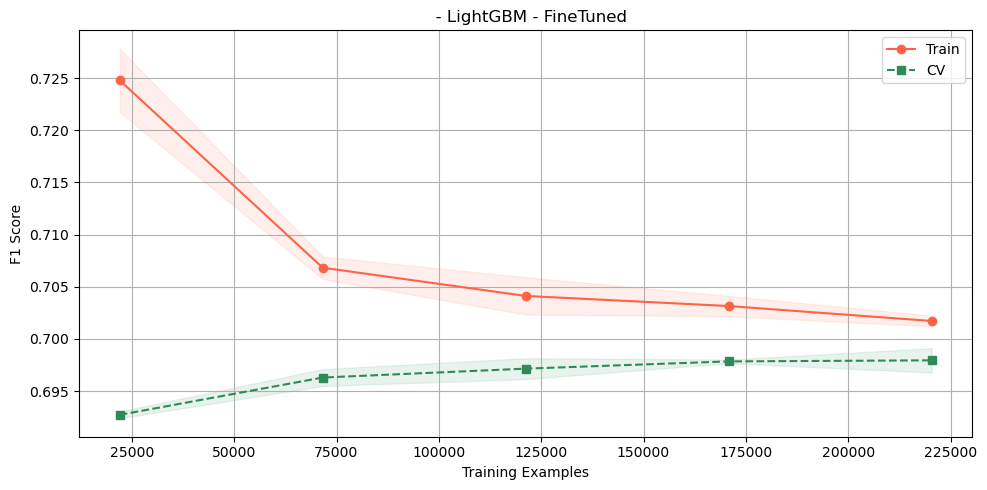

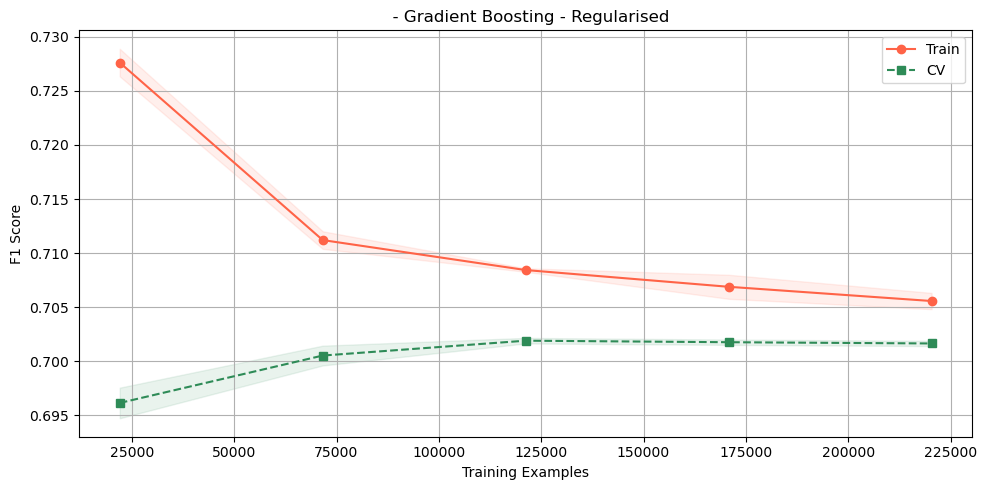

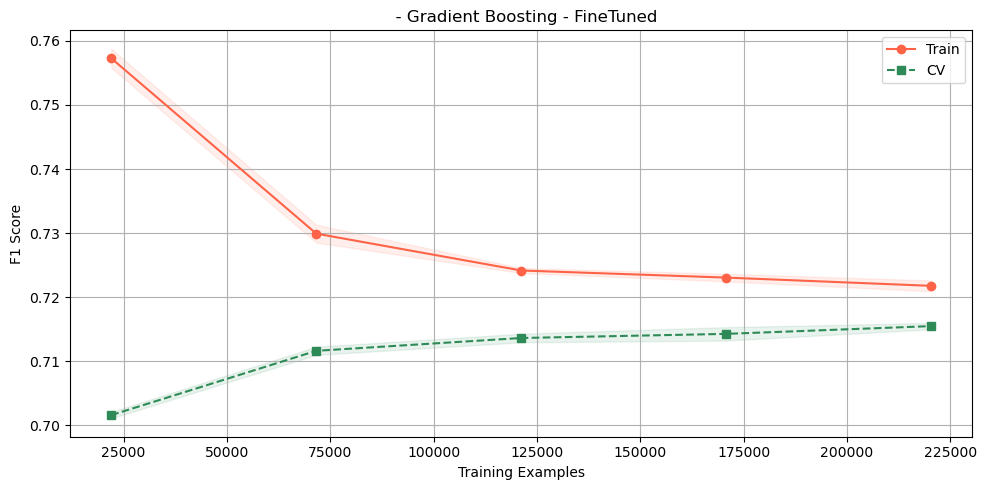

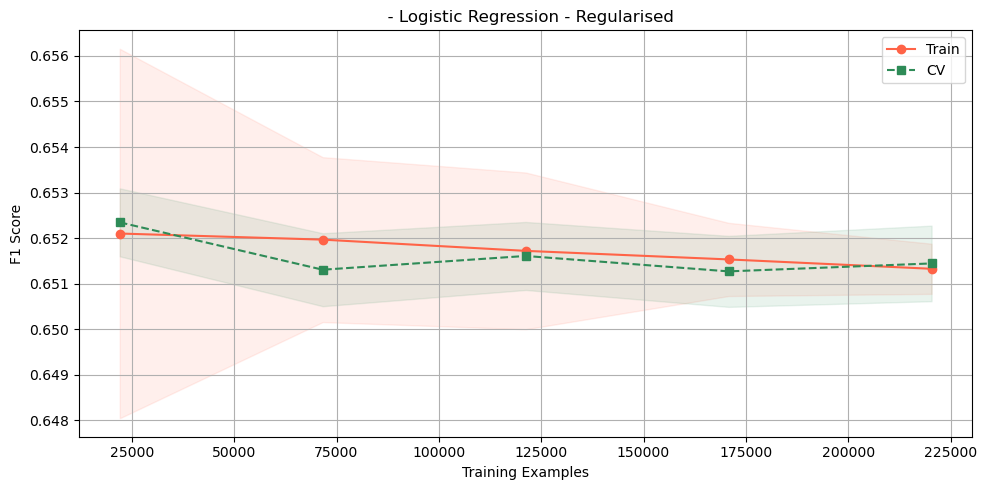

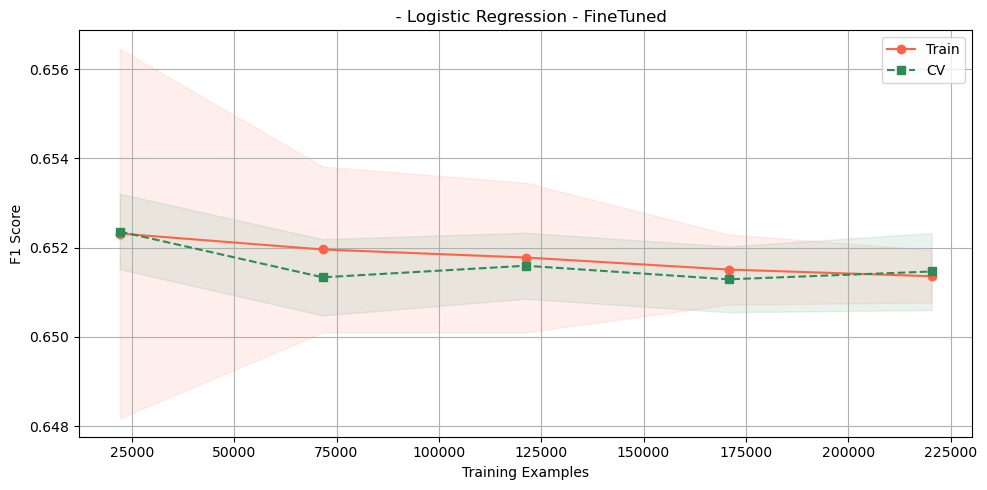

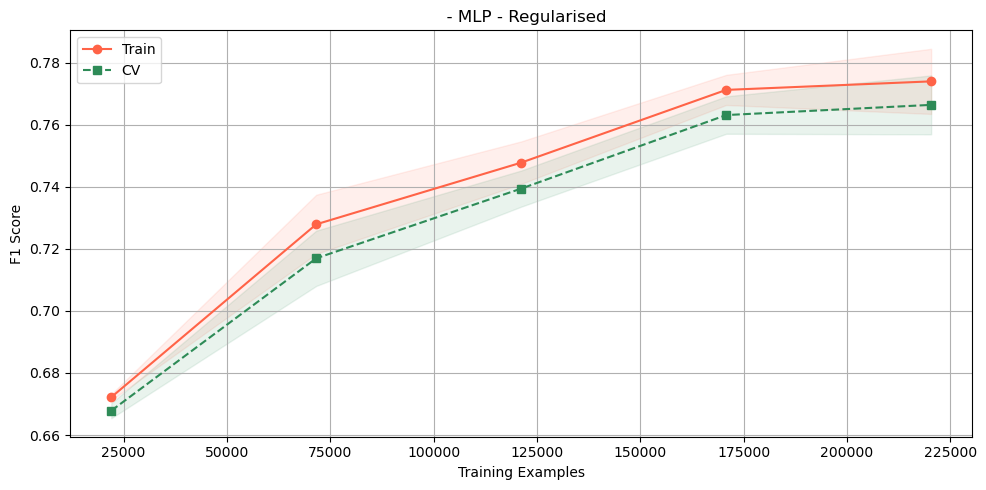

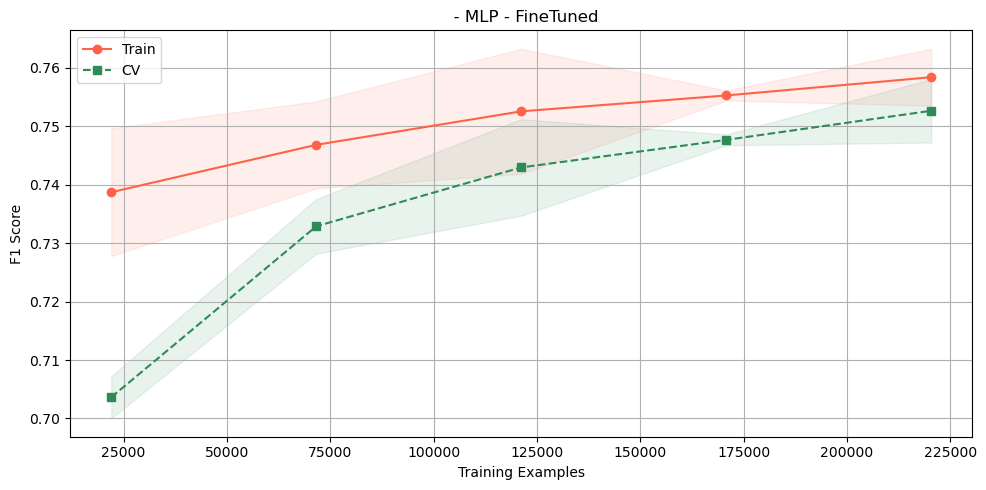

In [180]:
plot_combined_learning_curves(
    learning_curve_data_dict=learning_curve_data_dict,
    title_prefix=" "
)

In [202]:
# Step 1: Extract fitted models (these MUST be fitted scikit-learn classifiers)
xgb_model = all_models.get("XGBoost - FineTuned")
lgbm_model = all_models.get("LightGBM - FineTuned")
gb_model = all_models.get("Gradient Boosting - FineTuned")

# Step 2: Verify they are valid estimators
print(f"xgb -> {type(xgb_model)}")
print(f"lgbm -> {type(lgbm_model)}")
print(f"gb   -> {type(gb_model)}")

xgb -> <class 'xgboost.sklearn.XGBClassifier'>
lgbm -> <class 'lightgbm.sklearn.LGBMClassifier'>
gb   -> <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


In [204]:
import sklearn
import xgboost
import lightgbm

print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("lightgbm:", lightgbm.__version__)

scikit-learn: 1.6.1
xgboost: 2.1.1
lightgbm: 4.6.0
